In [99]:
## Install libraries

#!pip install boto3

In [1]:
import matplotlib.pyplot as plt
from glob import glob #library that helps us search for files
import scipy
import random
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from scipy.special import inv_boxcox
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import boto3
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import scipy.stats as stats
import scipy
import json

# custom package
import importlib
import package
importlib.reload(package)

from package.data_retrieval.data_retrieval import s3_retrieval, write_to_s3
from package.eda.data_exploration import correlation

from io import BytesIO
import io

pd.pandas.set_option('display.max_rows',None)
pd.pandas.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)


from sklearn import set_config
set_config(transform_output = 'pandas')

import warnings
warnings.simplefilter(action="ignore")

In [3]:
config = {}

# Connect to AWS S3

In [2]:
# get access key
secret = pd.read_csv("C:/Users/Oamen/Downloads/jupyter_iam_accessKeys.csv")

In [3]:
# create S3 client object 
s3_client = boto3.client('s3',aws_access_key_id=secret['Access key ID'][0],aws_secret_access_key=secret['Secret access key'][0])

In [4]:
bucket = 'auto-insurance-data-x'
test_file_name = "raw_data/test.csv"
train_file_name = 'raw_data/train.csv'

In [7]:
config['EDA'] = {}

config['EDA']['bucket_name'] = bucket
config['EDA']['test_file_name'] = test_file_name
config['EDA']['train_file_name'] = train_file_name

In [8]:
out_of_sample = s3_retrieval(s3_client, bucket, test_file_name)
out_of_sample[:1]

Retrieved object
Read bytes
Success!


id  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  ps_ind_05_cat  \
0   0          0              1          8              1              0   

   ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin  ps_ind_10_bin  \
0              0              1              0              0              0   

   ps_ind_11_bin  ps_ind_12_bin  ps_ind_13_bin  ps_ind_14  ps_ind_15  \
0              0              0              0          0         12   

   ps_ind_16_bin  ps_ind_17_bin  ps_ind_18_bin  ps_reg_01  ps_reg_02  \
0              1              0              0        0.5        0.3   

   ps_reg_03  ps_car_01_cat  ps_car_02_cat  ps_car_03_cat  ps_car_04_cat  \
0   0.610328              7              1             -1              0   

   ps_car_05_cat  ps_car_06_cat  ps_car_07_cat  ps_car_08_cat  ps_car_09_cat  \
0             -1              1              1              1              2   

   ps_car_10_cat  ps_car_11_cat  ps_car_11  ps_car_12  ps_car_13  ps_car_14  \
0              1             65          1   0.316228   0.669556   0.352136   

   ps_car_15  ps_calc_01  ps_calc_02  ps_calc_03  ps_calc_04  ps_calc_05  \
0   3.464102         0.1         0.8         0.6           1           1   

   ps_calc_06  ps_calc_07  ps_calc_08  ps_calc_09  ps_calc_10  ps_calc_11  \
0           6           3           6           2           9           1   

   ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  ps_calc_16_bin  \
0           1           1          12               0               1   

   ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  ps_calc_20_bin  
0               1               0               0               1

In [5]:
train = s3_retrieval(s3_client, bucket, train_file_name)
train[:1]

Retrieved object
Read bytes
Success!


id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin  \
0              0              0              1              0              0   

   ps_ind_10_bin  ps_ind_11_bin  ps_ind_12_bin  ps_ind_13_bin  ps_ind_14  \
0              0              0              0              0          0   

   ps_ind_15  ps_ind_16_bin  ps_ind_17_bin  ps_ind_18_bin  ps_reg_01  \
0         11              0              1              0        0.7   

   ps_reg_02  ps_reg_03  ps_car_01_cat  ps_car_02_cat  ps_car_03_cat  \
0        0.2    0.71807             10              1             -1   

   ps_car_04_cat  ps_car_05_cat  ps_car_06_cat  ps_car_07_cat  ps_car_08_cat  \
0              0              1              4              1              0   

   ps_car_09_cat  ps_car_10_cat  ps_car_11_cat  ps_car_11  ps_car_12  \
0              0              1             12          2        0.4   

   ps_car_13  ps_car_14  ps_car_15  ps_calc_01  ps_calc_02  ps_calc_03  \
0   0.883679    0.37081   3.605551         0.6         0.5         0.2   

   ps_calc_04  ps_calc_05  ps_calc_06  ps_calc_07  ps_calc_08  ps_calc_09  \
0           3           1          10           1          10           1   

   ps_calc_10  ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           5           9           1           5           8               0   

   ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
0               1               1               0               0   

   ps_calc_20_bin  
0               1

# Replace -1 with nan

In [10]:
for column in train.columns:
    
    train[column] = np.where(train[column] == -1, np.nan, train[column])

# Split Data for model selection - Stratified sampling

In [11]:
train.shape

(595212, 59)

In [6]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15, random_state = 0)

for train_index, test_index in split.split(train, train['target']):
    
    full_train = train.loc[train_index]
    test = train.loc[test_index]

In [7]:
full_train = full_train.reset_index(drop = True)
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15, random_state = 0)

for train_index, test_index in split.split(full_train, full_train['target']):
    
    red_train = full_train.loc[train_index]
    validation = full_train.loc[test_index]

In [14]:
whole_data = [full_train, test, red_train, validation]

[dataset.shape for dataset in whole_data]

[(505930, 59), (89282, 59), (430040, 59), (75890, 59)]

## Write data to S3

In [15]:
config['EDA']['full_train_path'] = 'split_data/full_train.csv'
config['EDA']['test_path'] = 'split_data/test.csv'
config['EDA']['validation_path'] = 'split_data/validation.csv'
config['EDA']['red_train_path'] = 'split_data/red_train.csv'

In [79]:
write_to_s3(full_train, s3_client, config['EDA']['bucket_name'] , config['EDA']['full_train_path'])

Success!


In [78]:
write_to_s3(validation, s3_client, config['EDA']['bucket_name'] , config['EDA']['validation_path'])

Success!


In [77]:
write_to_s3(test, s3_client, config['EDA']['bucket_name'] , config['EDA']['test_path'])

Success!


In [9]:
write_to_s3(red_train, s3_client,bucket , 'split_data/red_train.csv')
#write_to_s3(red_train, s3_client, config['EDA']['bucket_name'] , config['EDA']['red_train_path'])

Success!


# Data Exploration

In [17]:
df = full_train.sample(100000)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 277791 to 18873
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              100000 non-null  float64
 1   target          100000 non-null  float64
 2   ps_ind_01       100000 non-null  float64
 3   ps_ind_02_cat   99970 non-null   float64
 4   ps_ind_03       100000 non-null  float64
 5   ps_ind_04_cat   99988 non-null   float64
 6   ps_ind_05_cat   99027 non-null   float64
 7   ps_ind_06_bin   100000 non-null  float64
 8   ps_ind_07_bin   100000 non-null  float64
 9   ps_ind_08_bin   100000 non-null  float64
 10  ps_ind_09_bin   100000 non-null  float64
 11  ps_ind_10_bin   100000 non-null  float64
 12  ps_ind_11_bin   100000 non-null  float64
 13  ps_ind_12_bin   100000 non-null  float64
 14  ps_ind_13_bin   100000 non-null  float64
 15  ps_ind_14       100000 non-null  float64
 16  ps_ind_15       100000 non-null  float64
 17  ps_ind

In [19]:
df.describe()

id        target      ps_ind_01  ps_ind_02_cat  \
count  1.000000e+05  100000.00000  100000.000000   99970.000000   
mean   7.427138e+05       0.03654       1.896060       1.359568   
std    4.297792e+05       0.18763       1.982381       0.663526   
min    3.500000e+01       0.00000       0.000000       1.000000   
25%    3.701445e+05       0.00000       0.000000       1.000000   
50%    7.417295e+05       0.00000       1.000000       1.000000   
75%    1.114178e+06       0.00000       3.000000       2.000000   
max    1.488027e+06       1.00000       7.000000       4.000000   

           ps_ind_03  ps_ind_04_cat  ps_ind_05_cat  ps_ind_06_bin  \
count  100000.000000   99988.000000   99027.000000  100000.000000   
mean        4.425780       0.419170       0.425601       0.393520   
std         2.704005       0.493426       1.359020       0.488533   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.000000       0.000000       0.000000   
50%         4.000000       0.000000       0.000000       0.000000   
75%         6.000000       1.000000       0.000000       1.000000   
max        11.000000       1.000000       6.000000       1.000000   

       ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin  ps_ind_10_bin  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.257360       0.163950       0.185170       0.000330   
std         0.437182       0.370232       0.388437       0.018163   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         1.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       ps_ind_11_bin  ps_ind_12_bin  ps_ind_13_bin      ps_ind_14  \
count  100000.000000   100000.00000  100000.000000  100000.000000   
mean        0.001860        0.00973       0.000990       0.012910   
std         0.043088        0.09816       0.031449       0.129397   
min         0.000000        0.00000       0.000000       0.000000   
25%         0.000000        0.00000       0.000000       0.000000   
50%         0.000000        0.00000       0.000000       0.000000   
75%         0.000000        0.00000       0.000000       0.000000   
max         1.000000        1.00000       1.000000       3.000000   

           ps_ind_15  ps_ind_16_bin  ps_ind_17_bin  ps_ind_18_bin  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        7.291770       0.659490       0.121010       0.155510   
std         3.555512       0.473883       0.326141       0.362392   
min         0.000000       0.000000       0.000000       0.000000   
25%         5.000000       0.000000       0.000000       0.000000   
50%         7.000000       1.000000       0.000000       0.000000   
75%        10.000000       1.000000       0.000000       0.000000   
max        13.000000       1.000000       1.000000       1.000000   

           ps_reg_01      ps_reg_02     ps_reg_03  ps_car_01_cat  \
count  100000.000000  100000.000000  81806.000000   99985.000000   
mean        0.610942       0.437254      0.892573       8.287903   
std         0.287667       0.403417      0.344801       2.514605   
min         0.000000       0.000000      0.061237       0.000000   
25%         0.400000       0.200000      0.633443       7.000000   
50%         0.700000       0.300000      0.800000       7.000000   
75%         0.900000       0.600000      1.081087      11.000000   
max         0.900000       1.800000      3.197753      11.000000   

       ps_car_02_cat  ps_car_03_cat  ps_car_04_cat  ps_car_05_cat  \
count   100000.00000   30977.000000  100000.000000   55337.000000   
mean         0.83088       0.598638       0.725850       0.521911   
std          0.37486       0.490182       2.154692       0.499524   
min          0.00000       0.000000 

## Duplicates

In [20]:
f'The dataset contains {round(len(df[df.duplicated()])/len(df),2)}% duplicates'

'The dataset contains 0.0% duplicates'

## Whitespaces

### In column names

In [21]:
[column for column in df.columns if ' ' in column]

[]

### In rows

In [22]:
{column: len(df[df[column] == ' ']) > 0 for column in df.columns}

{'id': False,
 'target': False,
 'ps_ind_01': False,
 'ps_ind_02_cat': False,
 'ps_ind_03': False,
 'ps_ind_04_cat': False,
 'ps_ind_05_cat': False,
 'ps_ind_06_bin': False,
 'ps_ind_07_bin': False,
 'ps_ind_08_bin': False,
 'ps_ind_09_bin': False,
 'ps_ind_10_bin': False,
 'ps_ind_11_bin': False,
 'ps_ind_12_bin': False,
 'ps_ind_13_bin': False,
 'ps_ind_14': False,
 'ps_ind_15': False,
 'ps_ind_16_bin': False,
 'ps_ind_17_bin': False,
 'ps_ind_18_bin': False,
 'ps_reg_01': False,
 'ps_reg_02': False,
 'ps_reg_03': False,
 'ps_car_01_cat': False,
 'ps_car_02_cat': False,
 'ps_car_03_cat': False,
 'ps_car_04_cat': False,
 'ps_car_05_cat': False,
 'ps_car_06_cat': False,
 'ps_car_07_cat': False,
 'ps_car_08_cat': False,
 'ps_car_09_cat': False,
 'ps_car_10_cat': False,
 'ps_car_11_cat': False,
 'ps_car_11': False,
 'ps_car_12': False,
 'ps_car_13': False,
 'ps_car_14': False,
 'ps_car_15': False,
 'ps_calc_01': False,
 'ps_calc_02': False,
 'ps_calc_03': False,
 'ps_calc_04': False,
 'p

## Missing Values

In [23]:
nulls = df.isnull().sum().sum()
total = np.product(df.shape)

nulls_per = round(nulls/total, 2)

f'The dataset contains {nulls_per}% null values'

'The dataset contains 0.02% null values'

In [24]:
df.isnull().mean()

id                0.00000
target            0.00000
ps_ind_01         0.00000
ps_ind_02_cat     0.00030
ps_ind_03         0.00000
ps_ind_04_cat     0.00012
ps_ind_05_cat     0.00973
ps_ind_06_bin     0.00000
ps_ind_07_bin     0.00000
ps_ind_08_bin     0.00000
ps_ind_09_bin     0.00000
ps_ind_10_bin     0.00000
ps_ind_11_bin     0.00000
ps_ind_12_bin     0.00000
ps_ind_13_bin     0.00000
ps_ind_14         0.00000
ps_ind_15         0.00000
ps_ind_16_bin     0.00000
ps_ind_17_bin     0.00000
ps_ind_18_bin     0.00000
ps_reg_01         0.00000
ps_reg_02         0.00000
ps_reg_03         0.18194
ps_car_01_cat     0.00015
ps_car_02_cat     0.00000
ps_car_03_cat     0.69023
ps_car_04_cat     0.00000
ps_car_05_cat     0.44663
ps_car_06_cat     0.00000
ps_car_07_cat     0.01897
ps_car_08_cat     0.00000
ps_car_09_cat     0.00090
ps_car_10_cat     0.00000
ps_car_11_cat     0.00000
ps_car_11         0.00000
ps_car_12         0.00000
ps_car_13         0.00000
ps_car_14         0.07298
ps_car_15   

<Axes: >

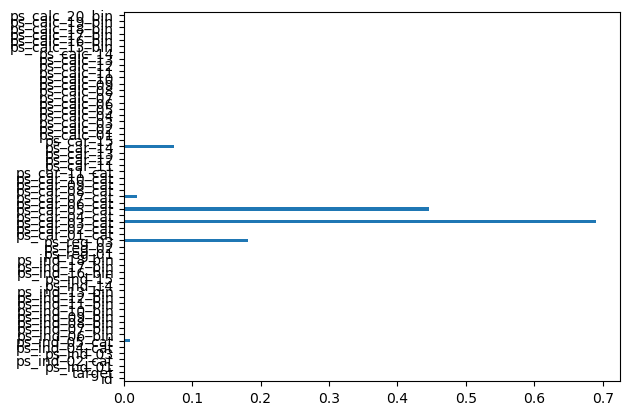

In [25]:
df.isnull().mean().plot(kind = 'barh')

## Split Data types

In [26]:
categorical = [column for column in df.columns if df[column].nunique() <= 10 and column!= 'target']
numerical = [column for column in df.columns if column not in categorical and column not in ['id', 'target']]

In [27]:
config['EDA']['categorical_columns'] = categorical
config['EDA']['numerical_columns'] = numerical
config['EDA']['target'] = 'target'

In [28]:
df[categorical][:2]

ps_ind_01  ps_ind_02_cat  ps_ind_04_cat  ps_ind_05_cat  ps_ind_06_bin  \
277791        1.0            1.0            0.0            0.0            1.0   
499356        7.0            1.0            0.0            0.0            1.0   

        ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin  ps_ind_10_bin  \
277791            0.0            0.0            0.0            0.0   
499356            0.0            0.0            0.0            0.0   

        ps_ind_11_bin  ps_ind_12_bin  ps_ind_13_bin  ps_ind_14  ps_ind_16_bin  \
277791            0.0            0.0            0.0        0.0            1.0   
499356            0.0            0.0            0.0        0.0            0.0   

        ps_ind_17_bin  ps_ind_18_bin  ps_reg_01  ps_car_02_cat  ps_car_03_cat  \
277791            0.0            0.0        0.9            1.0            NaN   
499356            0.0            1.0        0.3            1.0            NaN   

        ps_car_04_cat  ps_car_05_cat  ps_car_07_cat  ps_car_08_cat  \
277791            0.0            NaN            1.0            1.0   
499356            0.0            1.0            1.0            1.0   

        ps_car_09_cat  ps_car_10_cat  ps_car_11  ps_calc_01  ps_calc_02  \
277791            2.0            1.0        2.0         0.6         0.4   
499356            0.0            1.0        3.0         0.2         0.2   

        ps_calc_03  ps_calc_04  ps_calc_05  ps_calc_06  ps_calc_07  \
277791         0.6         4.0         1.0         9.0         1.0   
499356         0.4         4.0         1.0         7.0         3.0   

        ps_calc_09  ps_calc_12  ps_calc_15_bin  ps_calc_16_bin  \
277791         1.0         5.0             0.0             0.0   
499356         6.0         0.0             0.0             0.0   

        ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  ps_calc_20_bin  
277791             1.0             0.0             1.0             0.0  
499356             1.0             0.0             0.0             1.0

## Univariate analysis and cardinality of categorical columns

In [29]:
for column in categorical + ['target']:
    
    num_unique = df[column].nunique()
    
    print(f'{column} contains {num_unique} unique values')
    
    print()
    
    if num_unique <= 7:
        
        print(f'Unique values in {column}:\n{df[column].unique()}')
        
        print(f'Frequency of unique values in {column}:\n{df[column].value_counts(normalize = True)}')

ps_ind_01 contains 8 unique values

ps_ind_02_cat contains 4 unique values

Unique values in ps_ind_02_cat:
[ 1.  2.  3. nan  4.]
Frequency of unique values in ps_ind_02_cat:
1.0    0.726168
2.0    0.207352
3.0    0.047224
4.0    0.019256
Name: ps_ind_02_cat, dtype: float64
ps_ind_04_cat contains 2 unique values

Unique values in ps_ind_04_cat:
[ 0.  1. nan]
Frequency of unique values in ps_ind_04_cat:
0.0    0.58083
1.0    0.41917
Name: ps_ind_04_cat, dtype: float64
ps_ind_05_cat contains 7 unique values

Unique values in ps_ind_05_cat:
[ 0.  6. nan  1.  3.  2.  4.  5.]
Frequency of unique values in ps_ind_05_cat:
0.0    0.894190
6.0    0.035516
4.0    0.031921
1.0    0.014228
3.0    0.014097
2.0    0.007311
5.0    0.002737
Name: ps_ind_05_cat, dtype: float64
ps_ind_06_bin contains 2 unique values

Unique values in ps_ind_06_bin:
[1. 0.]
Frequency of unique values in ps_ind_06_bin:
0.0    0.60648
1.0    0.39352
Name: ps_ind_06_bin, dtype: float64
ps_ind_07_bin contains 2 unique values

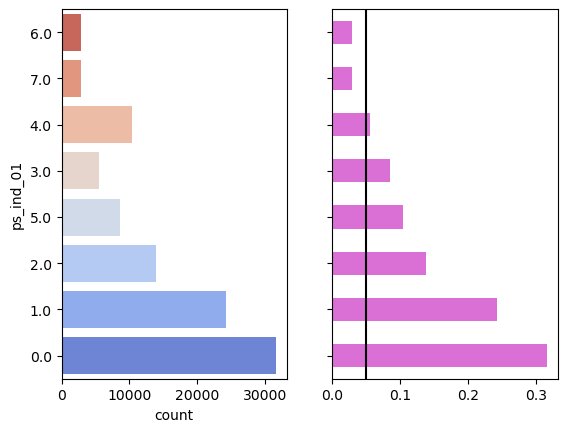

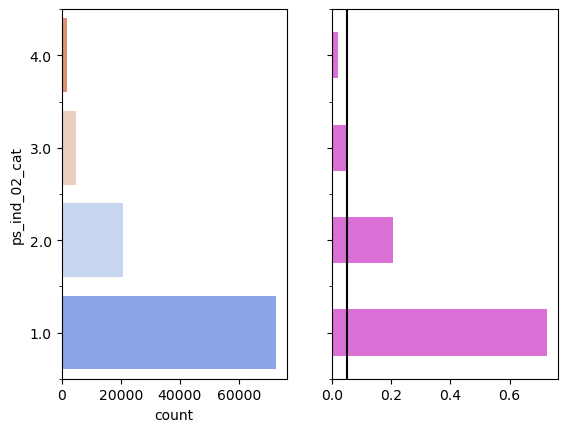

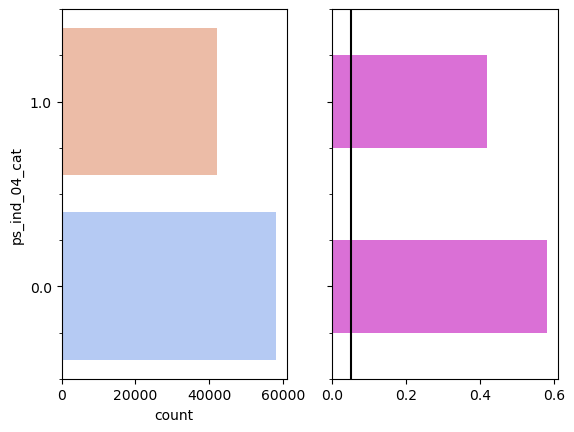

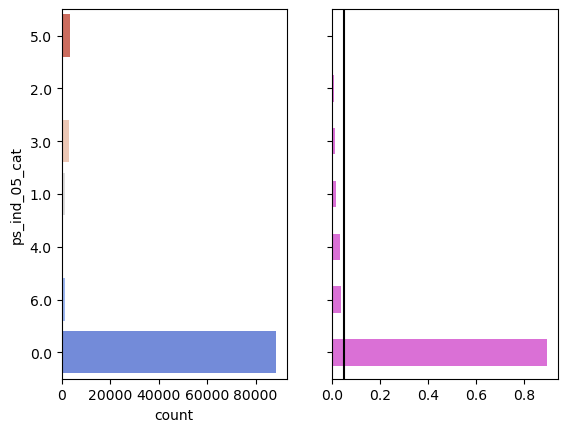

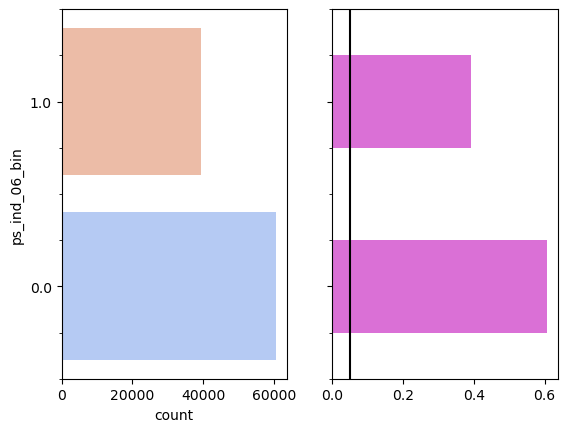

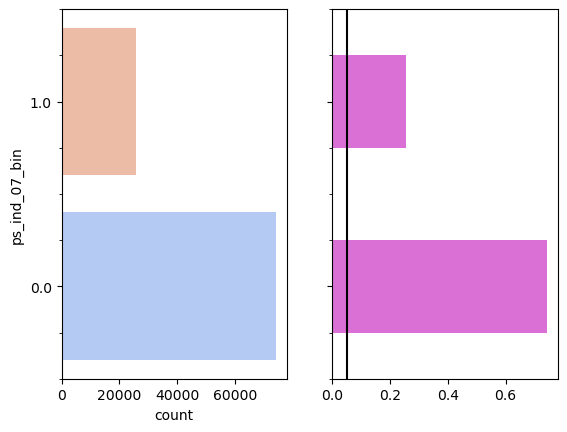

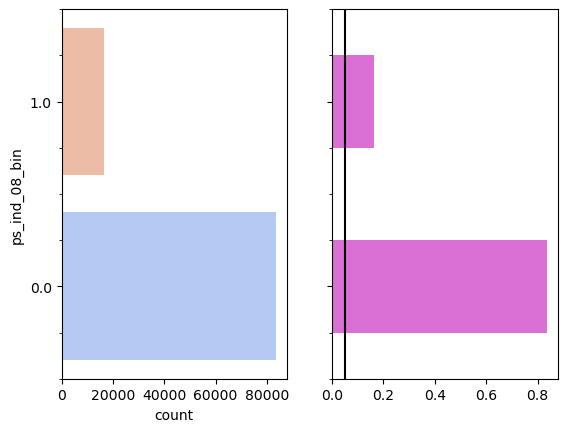

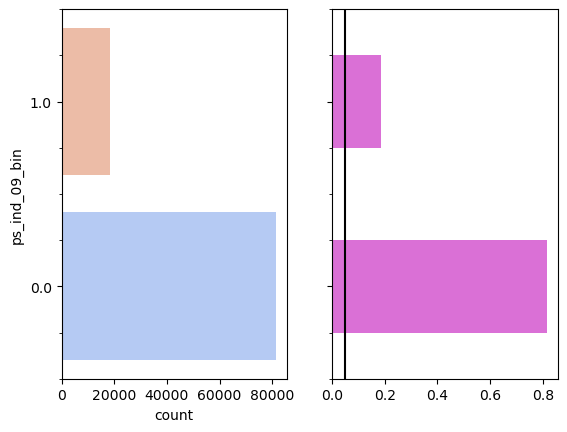

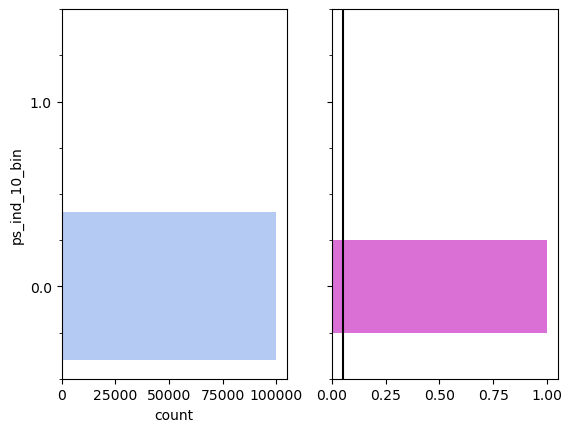

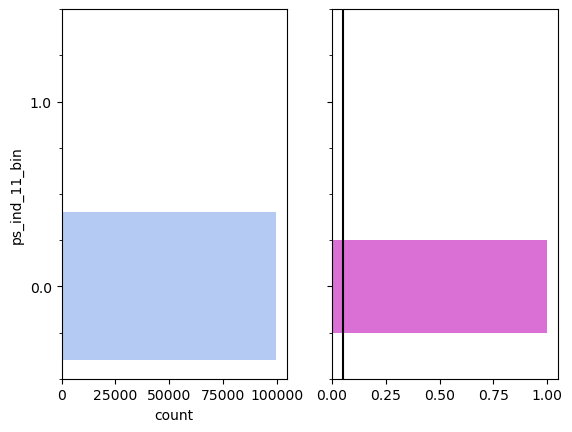

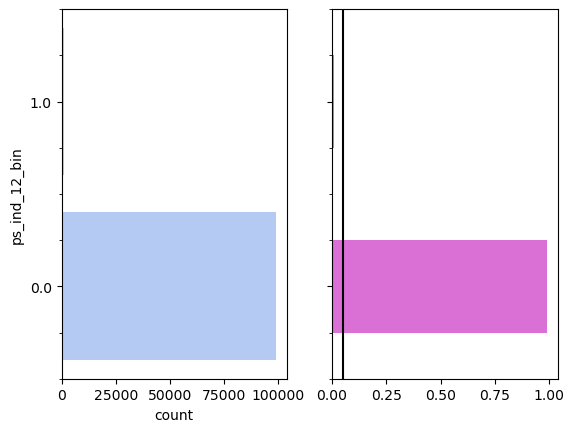

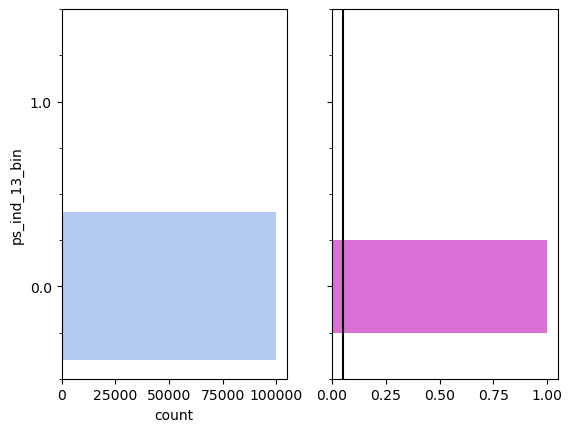

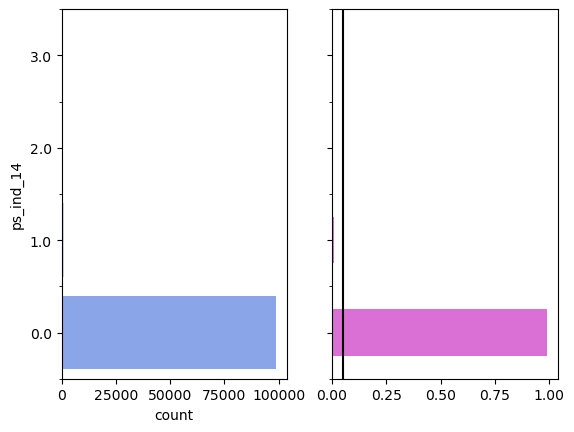

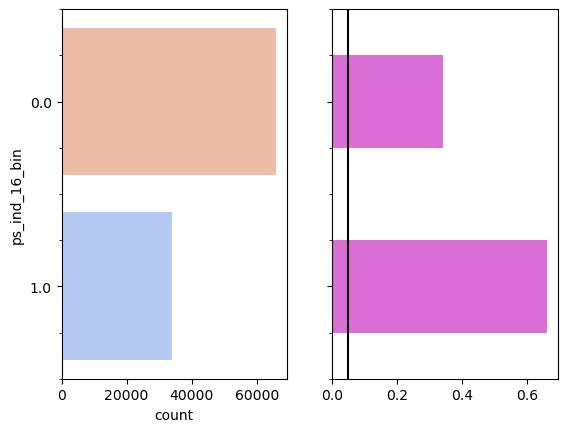

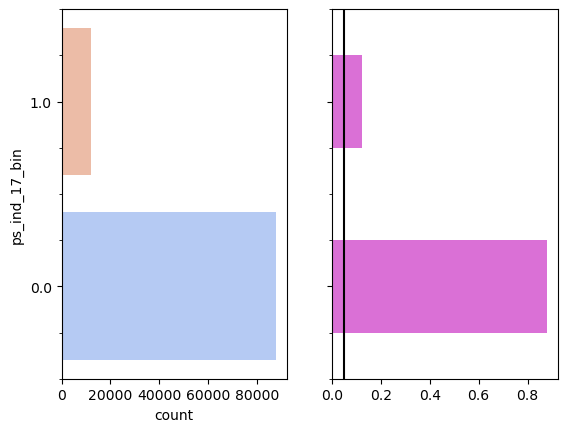

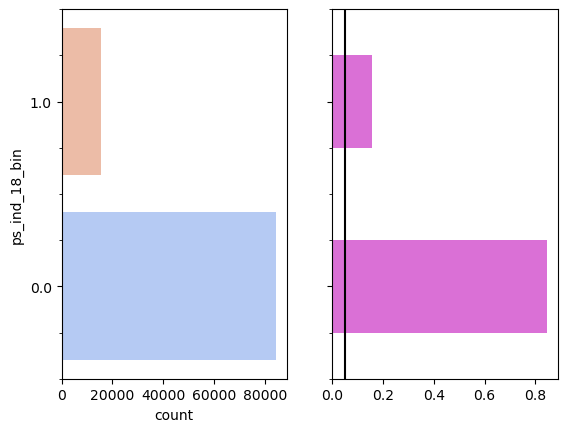

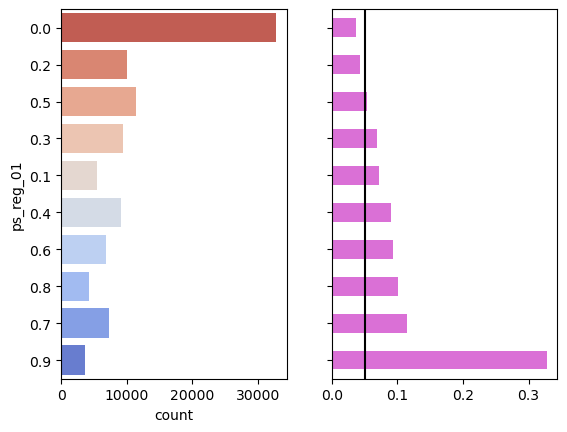

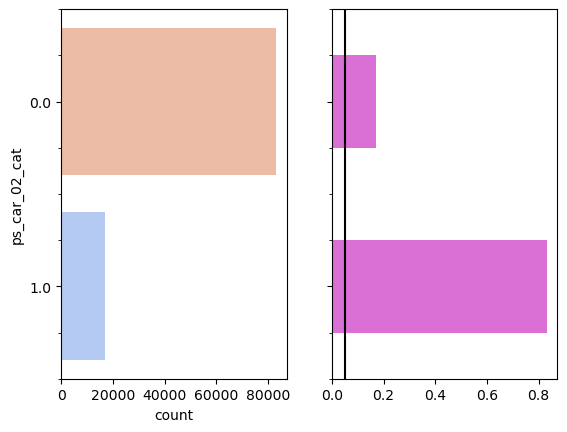

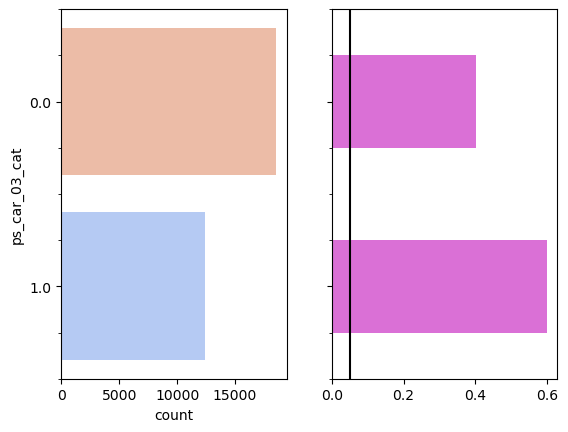

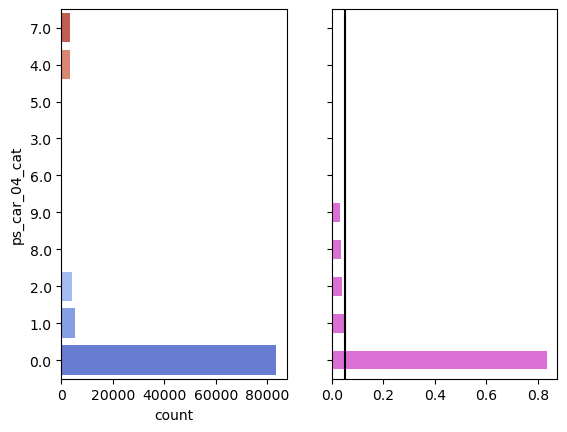

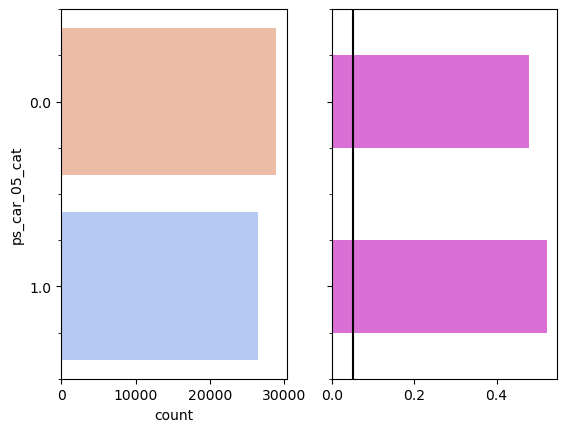

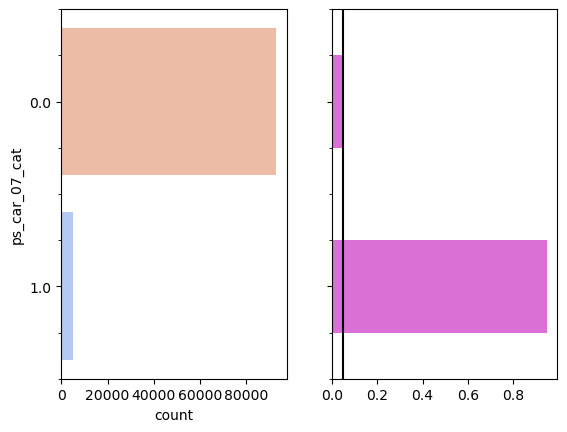

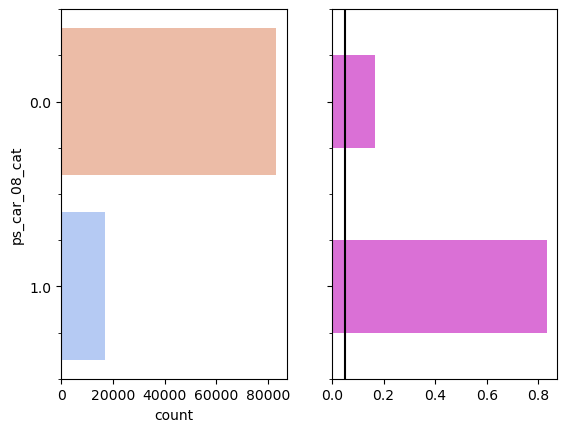

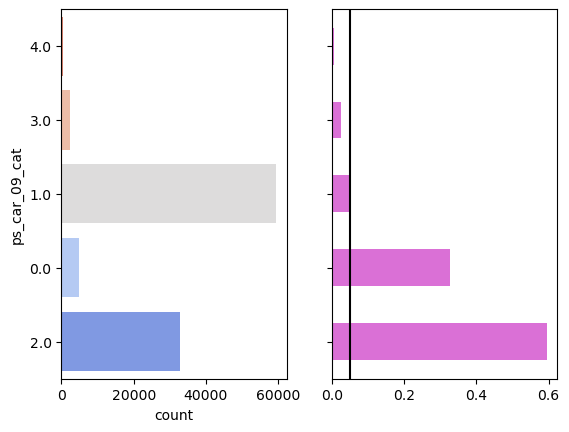

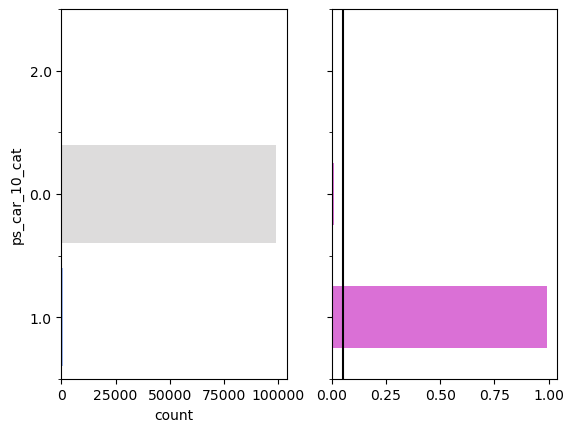

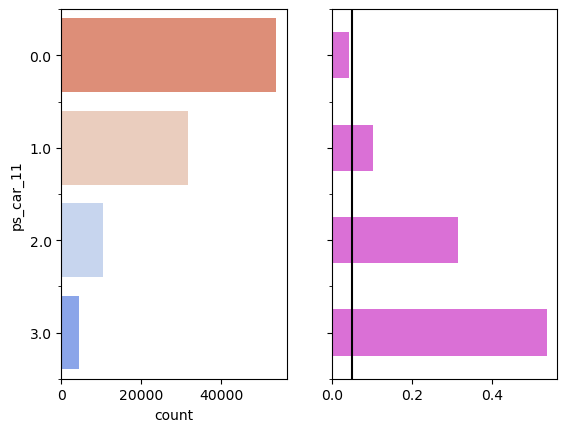

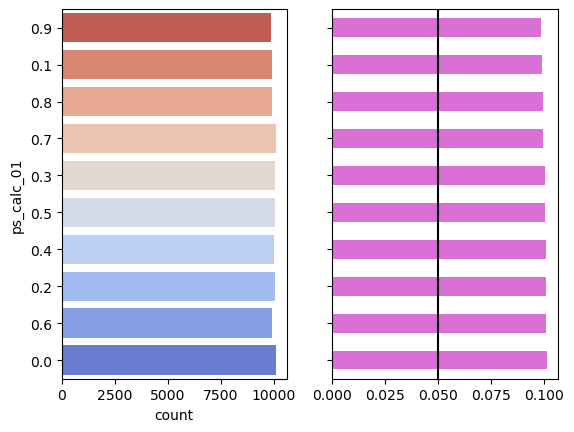

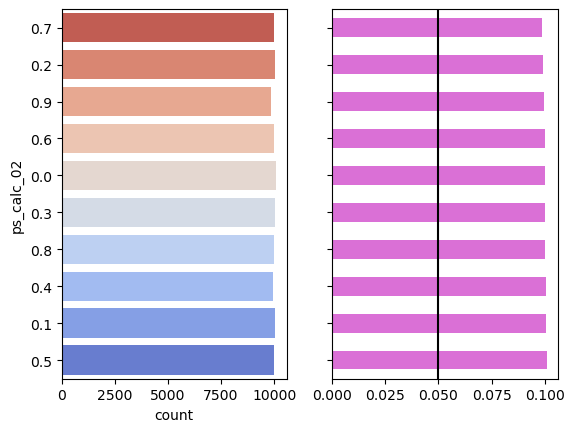

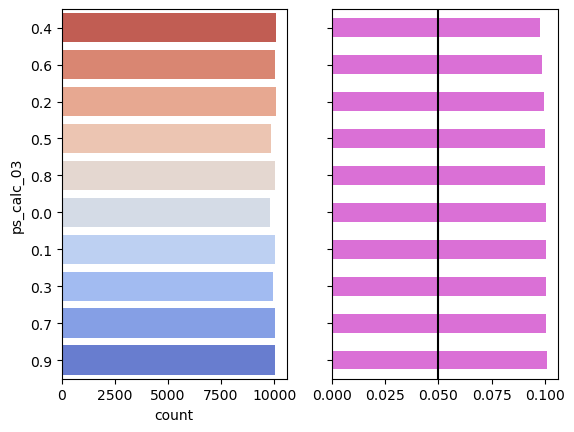

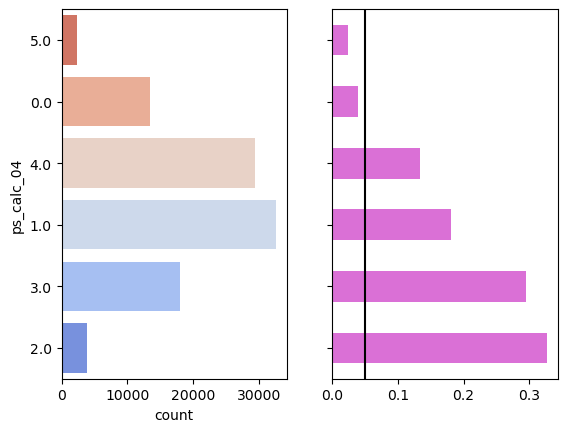

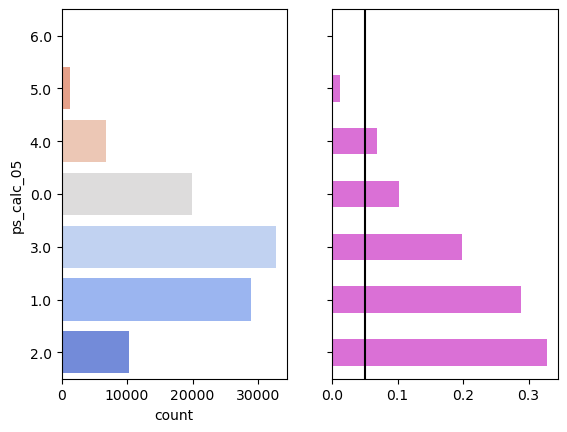

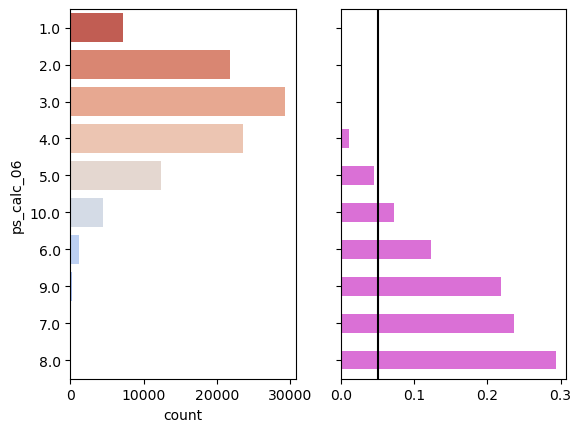

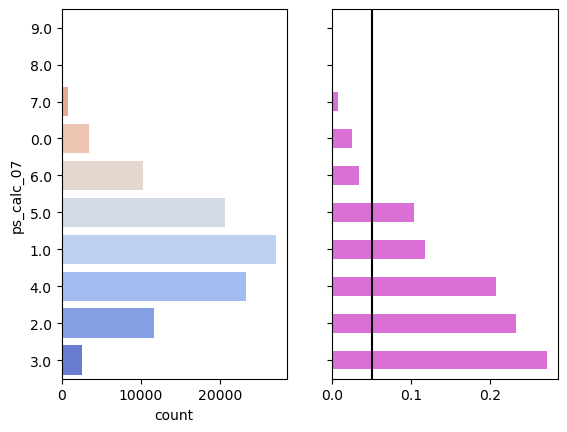

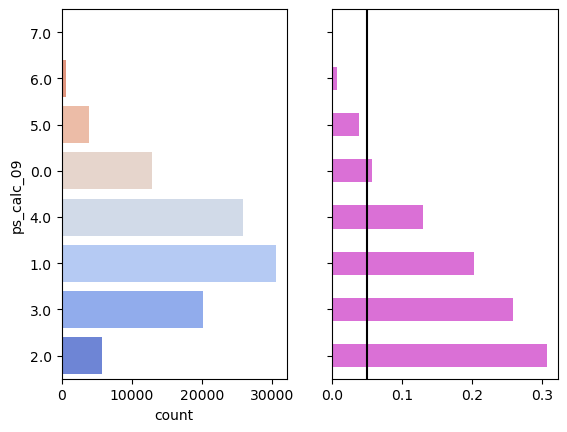

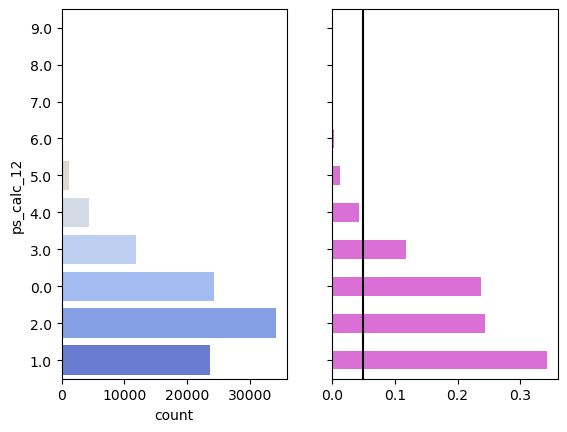

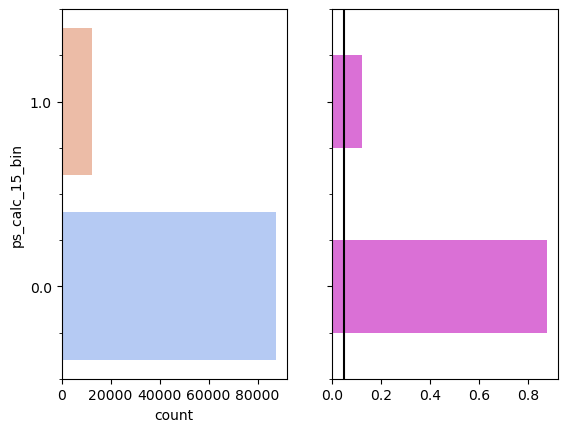

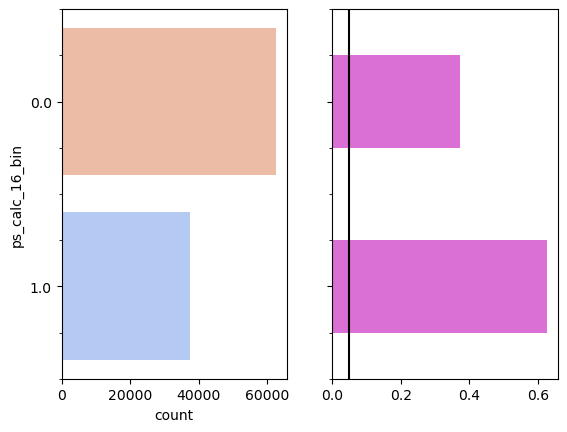

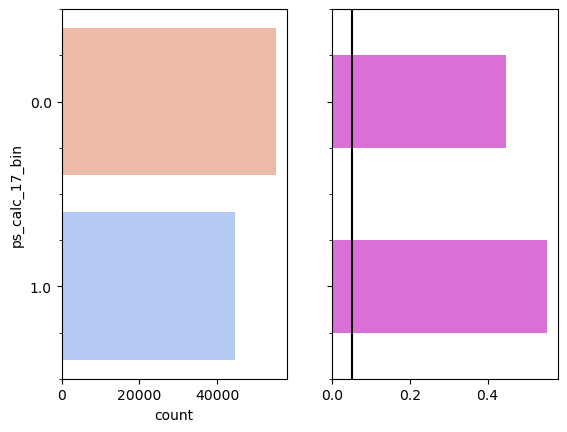

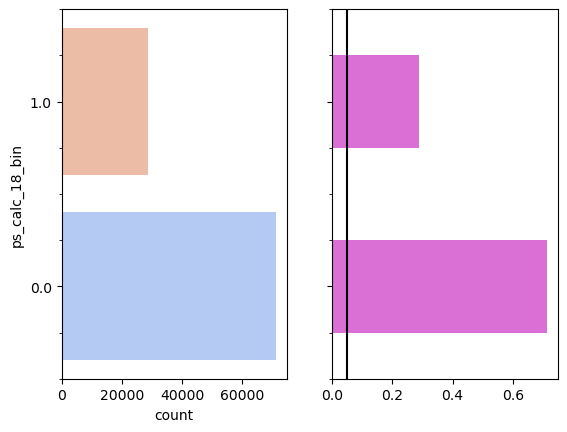

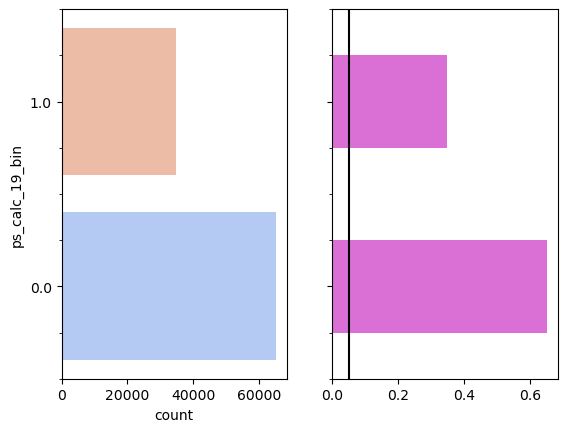

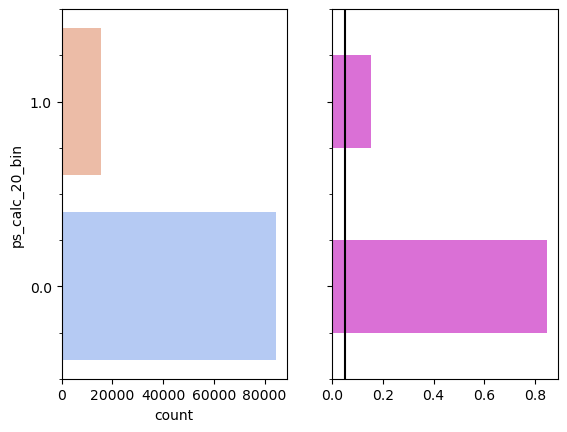

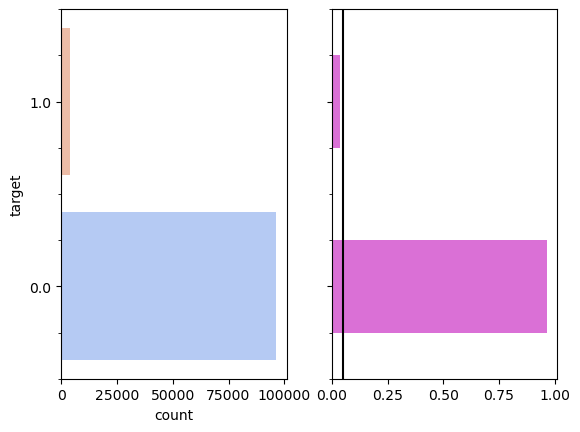

In [30]:
for column in categorical + ['target']:
    
    fig, axs = plt.subplots(1,2, sharey = True)
    
    sns.countplot(data = df, y = column, palette = 'coolwarm', ax = axs[0])
    
    df[column].value_counts(normalize = True, sort = True).plot(kind = 'barh', color = 'orchid', ax = axs[1])
    
    axs[1].axvline(0.05, color = 'k')

## Univariate analysis and distribution of numerical columns

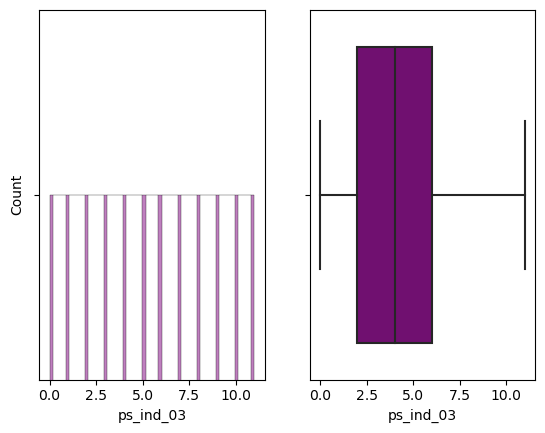

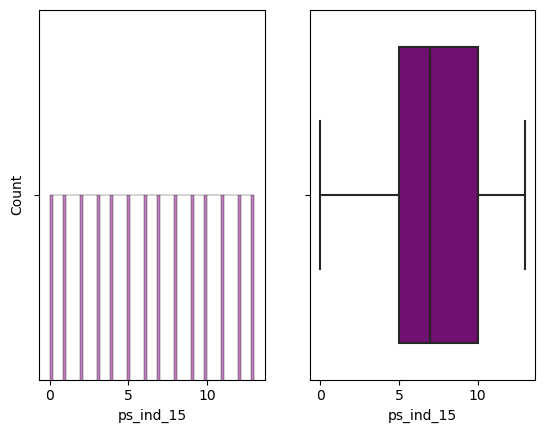

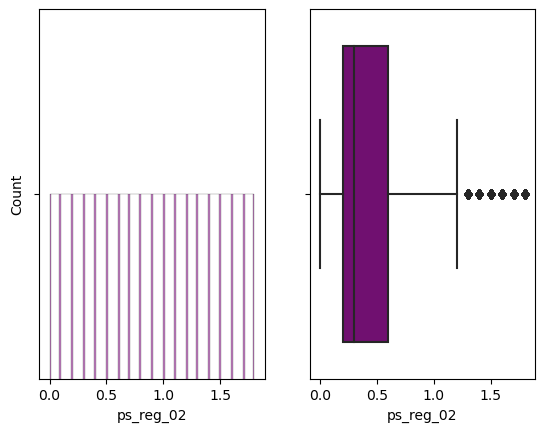

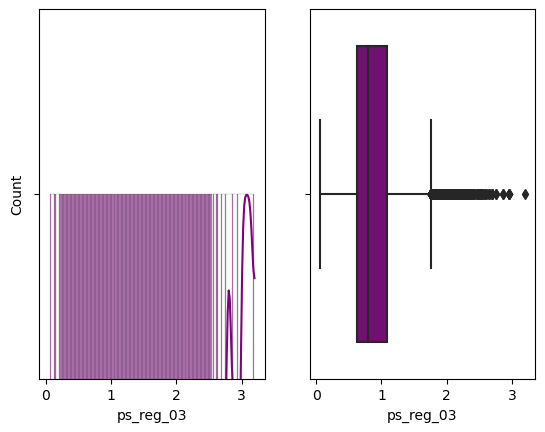

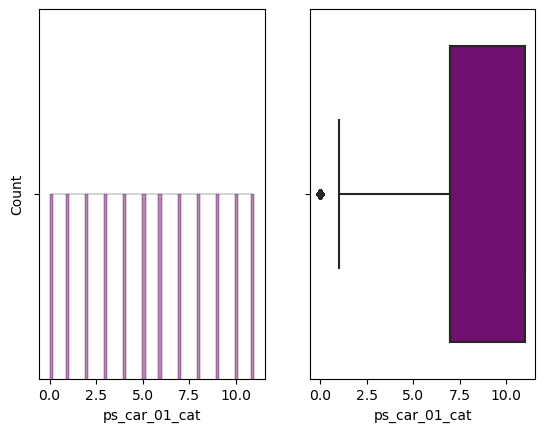

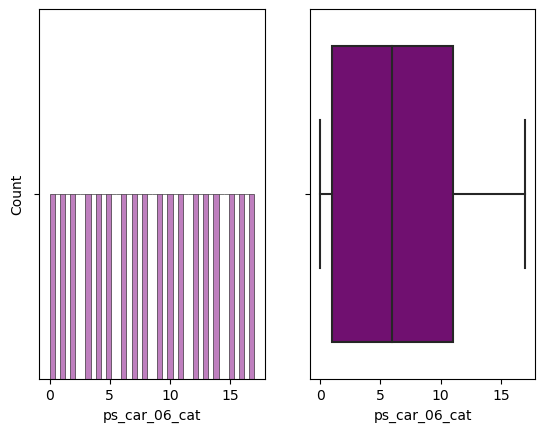

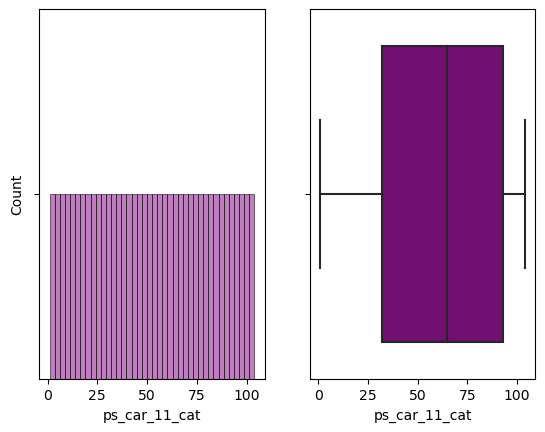

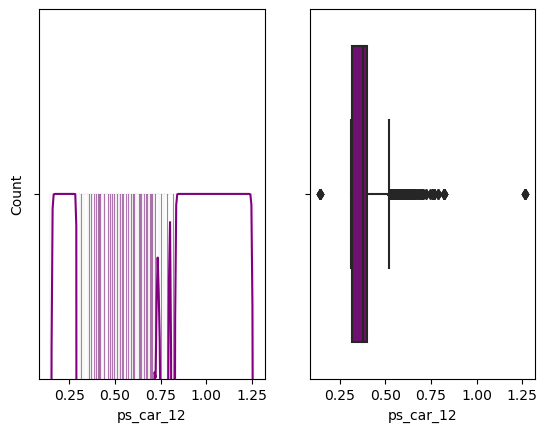

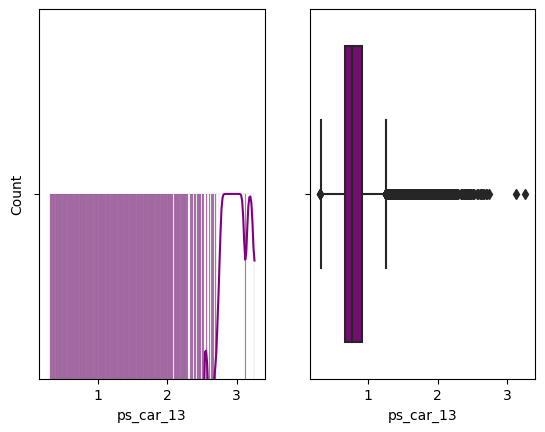

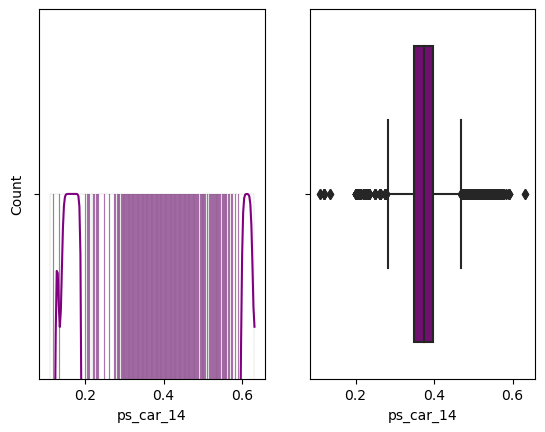

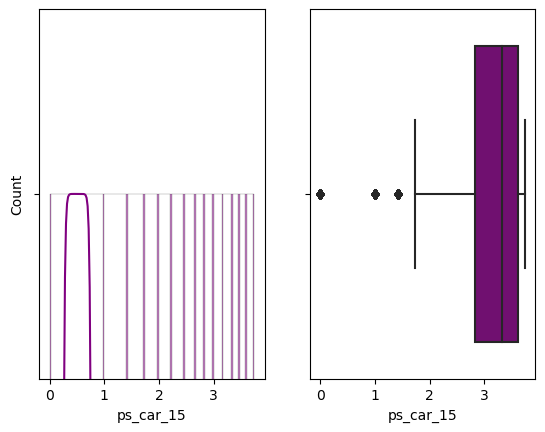

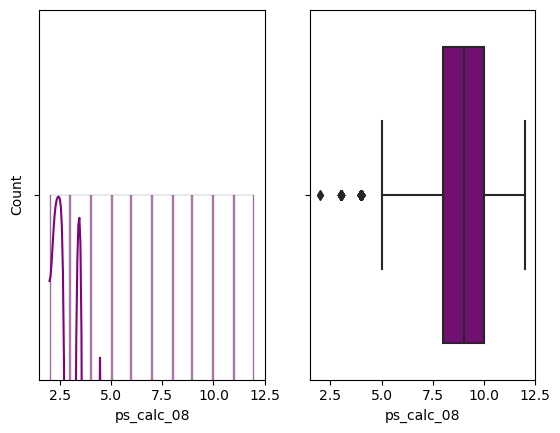

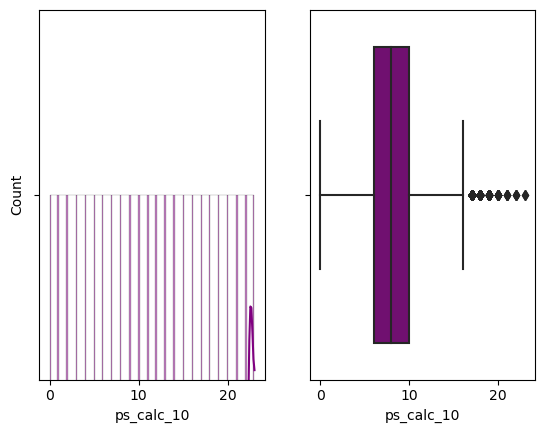

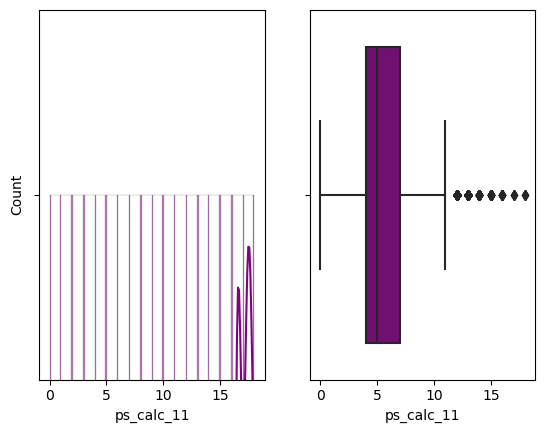

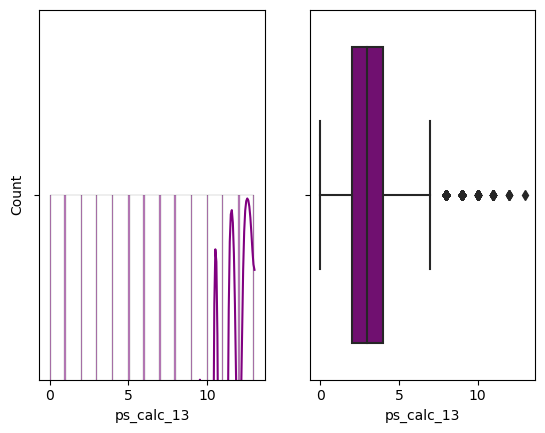

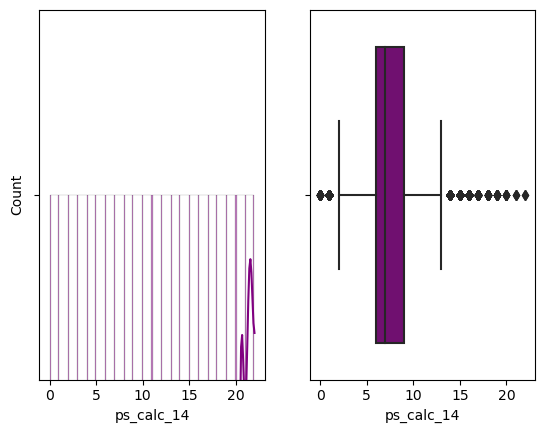

In [31]:
for column in numerical:
    
    fig, axs = plt.subplots(1,2, sharey = True)
    
    sns.histplot(data = df, x = column, color = 'purple', ax = axs[0], kde = True)
    
    sns.boxplot(data = df, x = column, color = 'purple', ax = axs[1])

## Bivariate

### Numerical vs Categorical

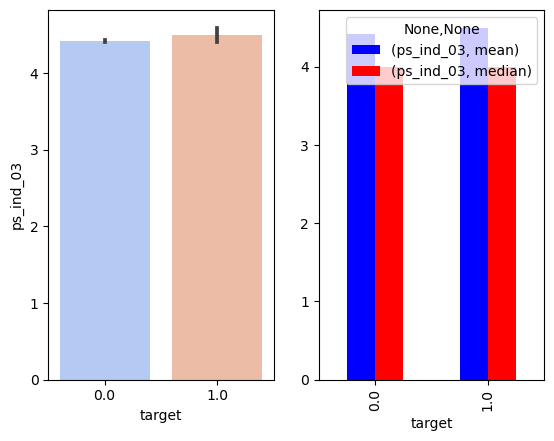

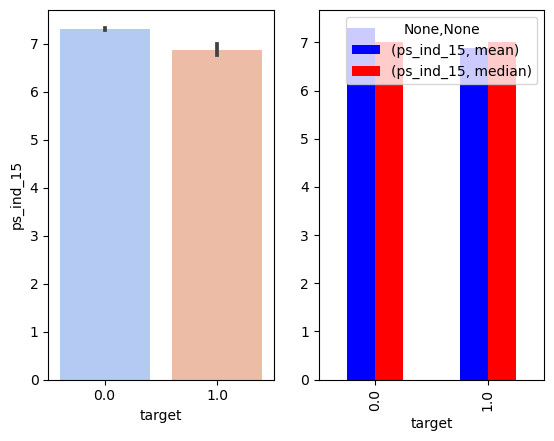

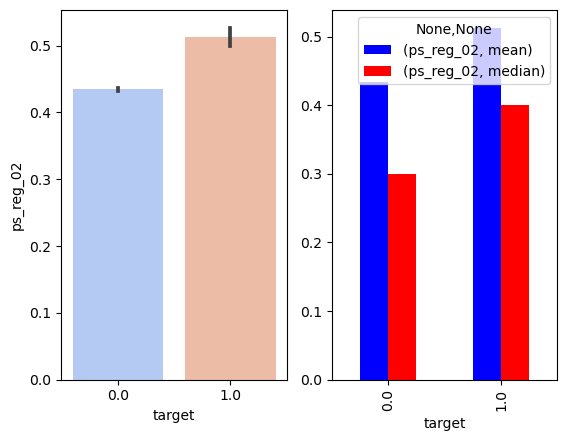

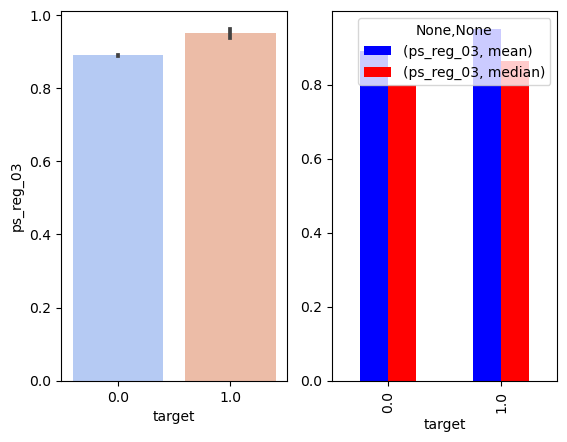

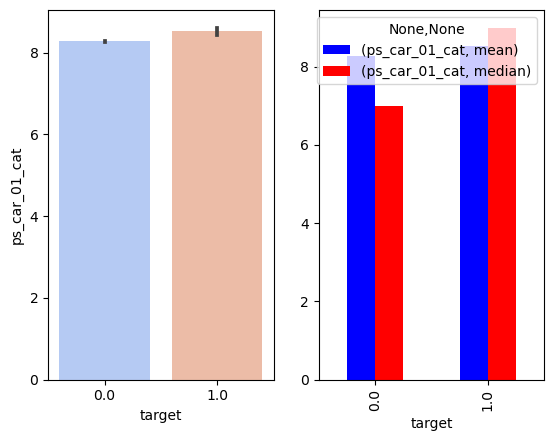

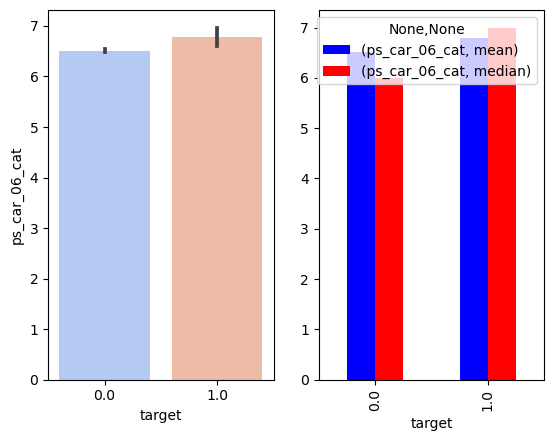

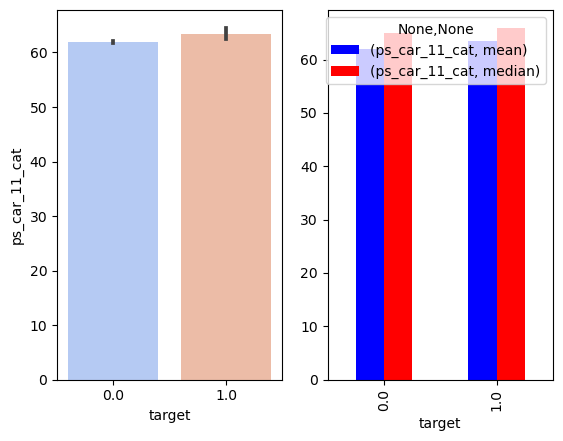

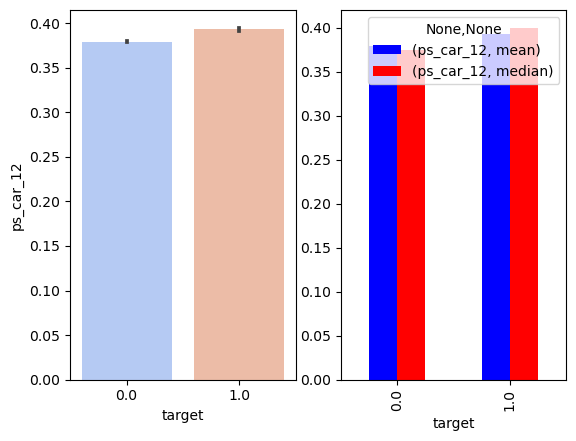

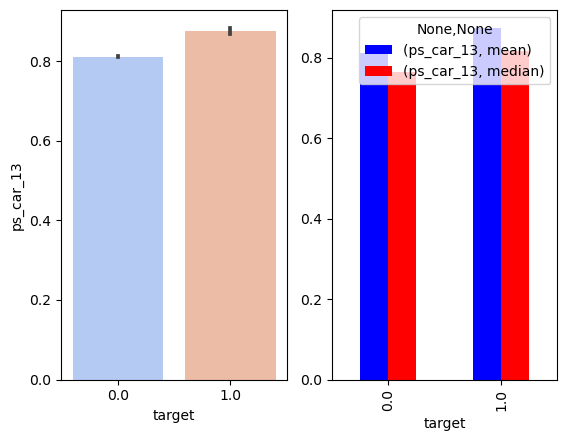

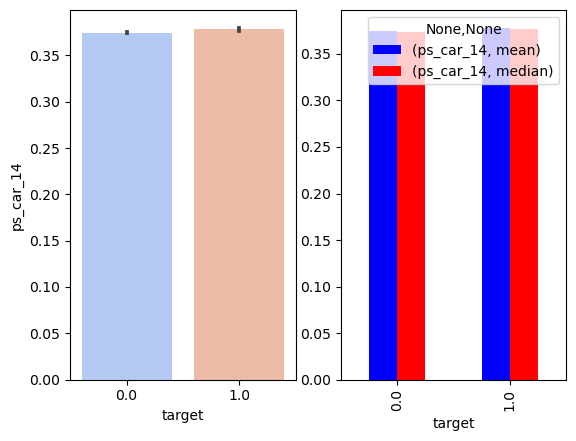

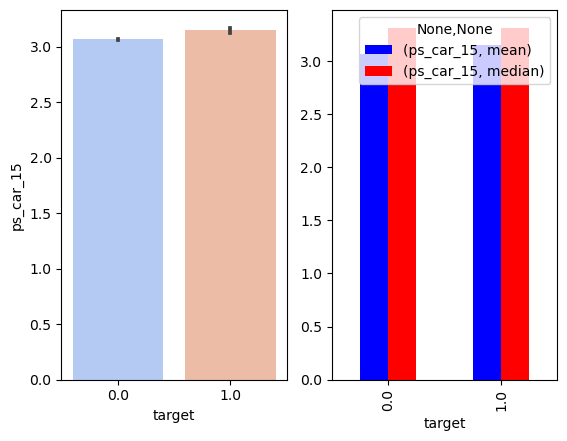

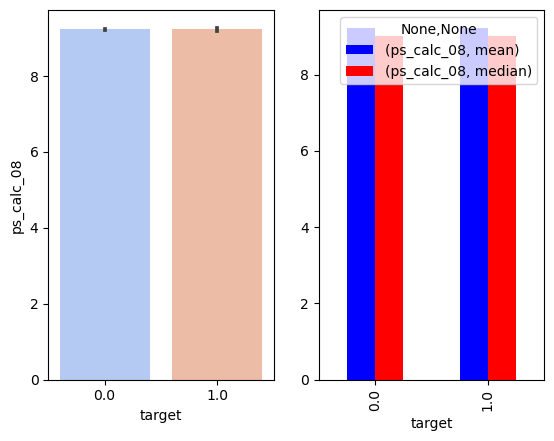

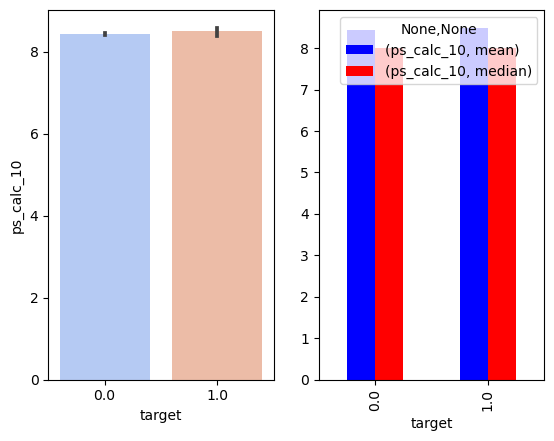

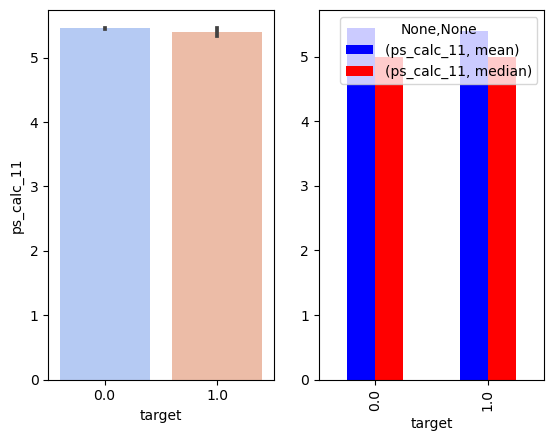

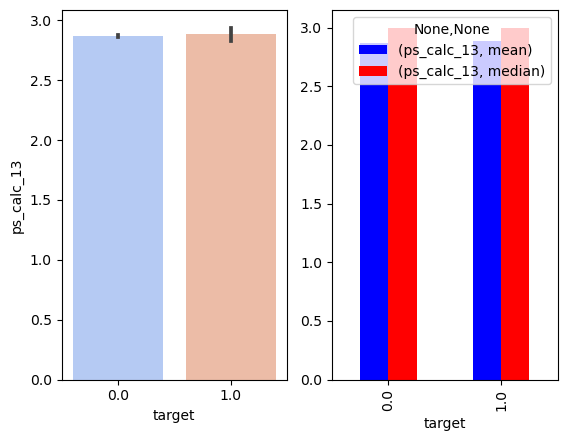

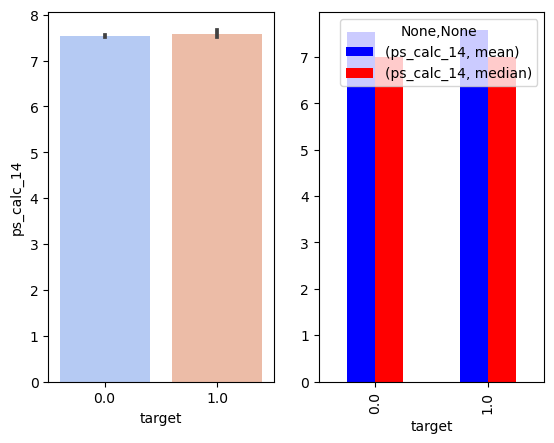

In [32]:
for column in numerical:
    
    fig, axs = plt.subplots(1,2)
    
    sns.barplot(data = df, x = config['EDA']['target'], y = column, palette = 'coolwarm', ax = axs[0])
    
    df.groupby(config['EDA']['target']).agg({column:['mean', 'median']}).plot(kind = 'bar', color = ['blue', 'red'], ax = axs[1])

In [33]:
for column in numerical:
    
    print(column)
    print(df.pivot_table(index = config['EDA']['target'], values = column, aggfunc = ['mean', 'median']))
    print('_________________________________________________________________________________')
    print()

ps_ind_03
            mean    median
       ps_ind_03 ps_ind_03
target                    
0.0     4.422830       4.0
1.0     4.503558       4.0
_________________________________________________________________________________

ps_ind_15
            mean    median
       ps_ind_15 ps_ind_15
target                    
0.0     7.307569       7.0
1.0     6.875205       7.0
_________________________________________________________________________________

ps_reg_02
            mean    median
       ps_reg_02 ps_reg_02
target                    
0.0     0.434371       0.3
1.0     0.513273       0.4
_________________________________________________________________________________

ps_reg_03
            mean    median
       ps_reg_03 ps_reg_03
target                    
0.0     0.890219  0.797653
1.0     0.951301  0.862772
_________________________________________________________________________________

ps_car_01_cat
                mean        median
       ps_car_01_cat ps_car_01_cat
targ

### Categorical vs Categorical

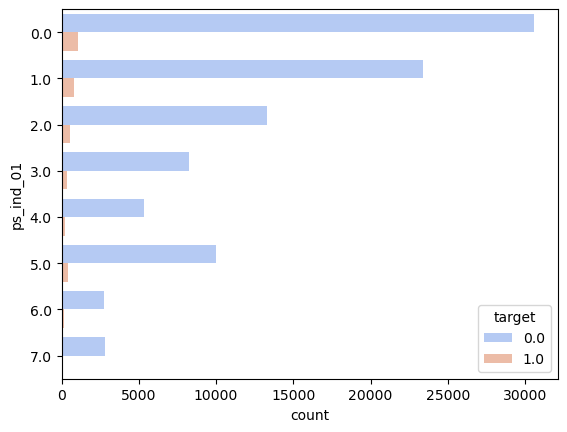

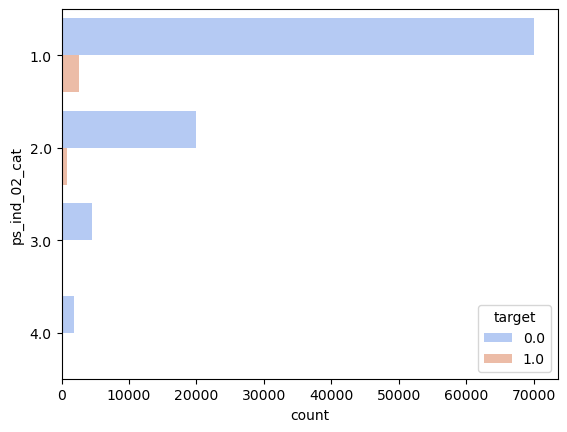

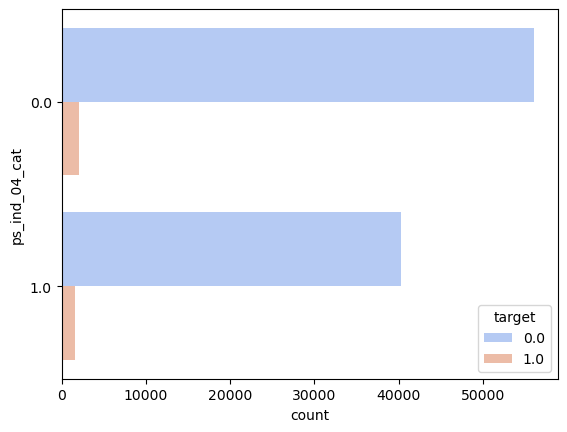

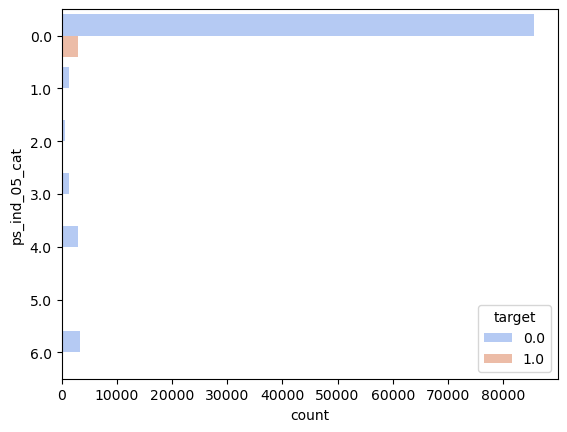

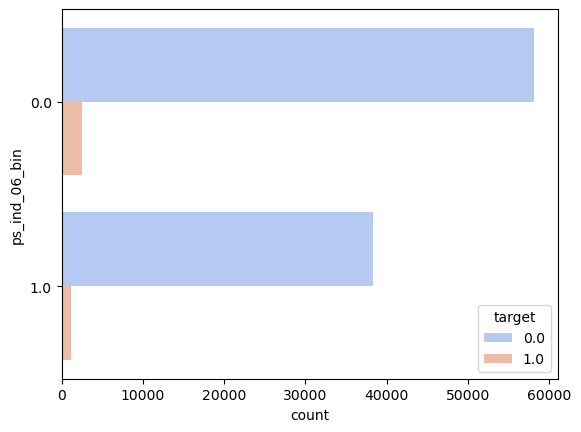

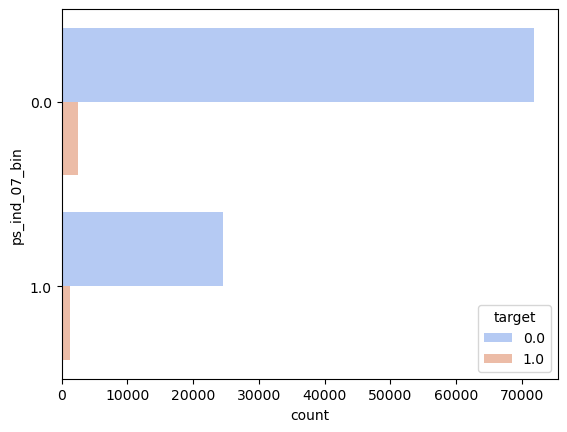

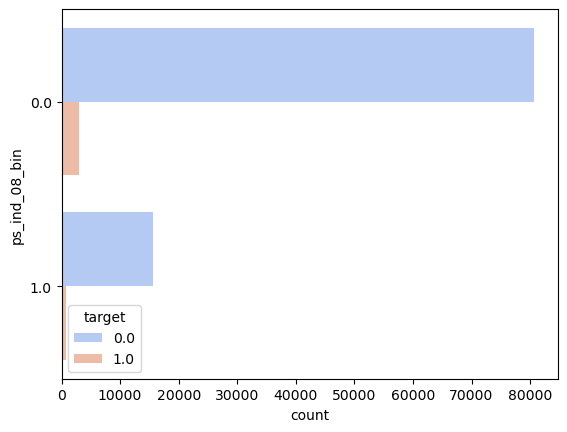

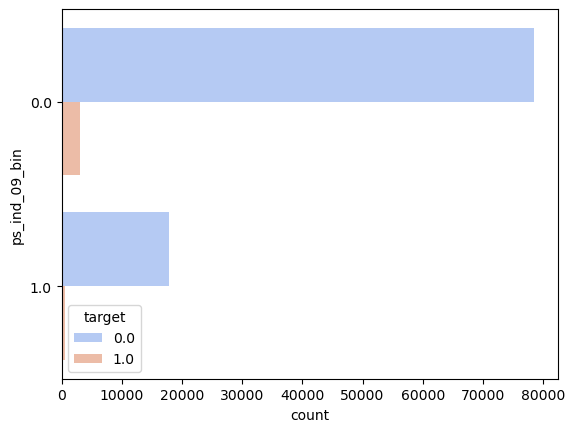

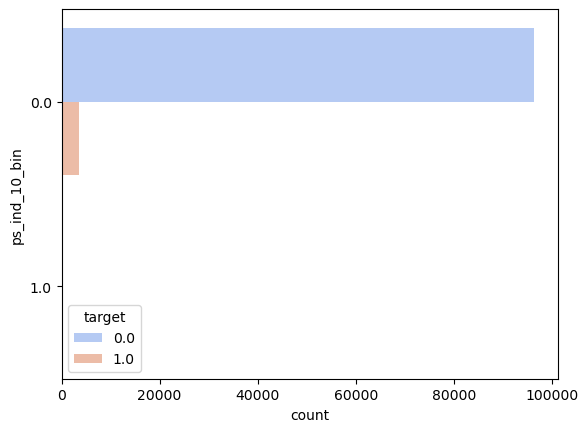

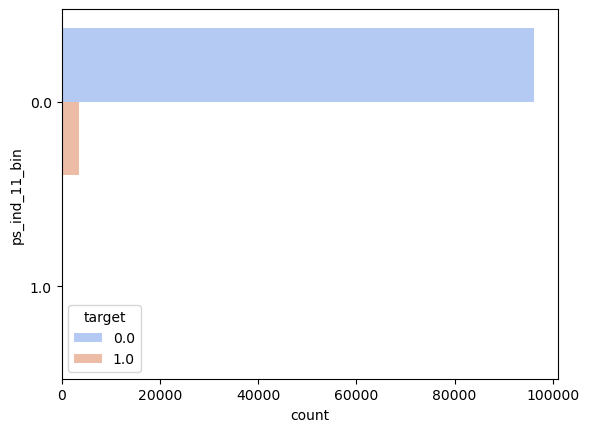

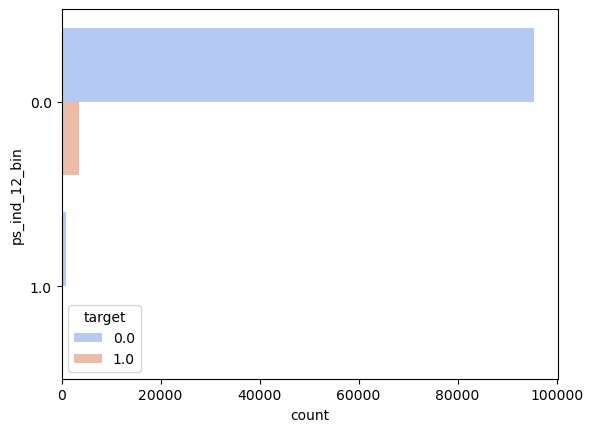

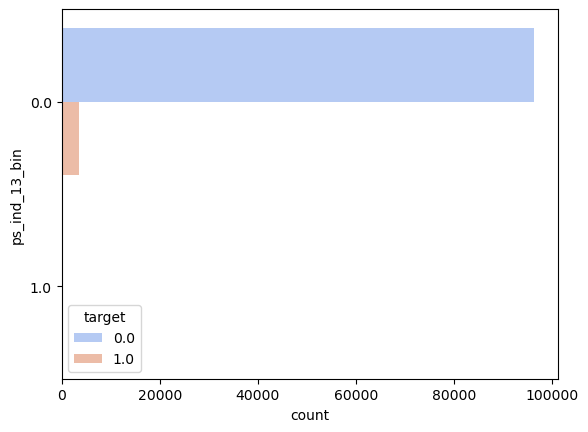

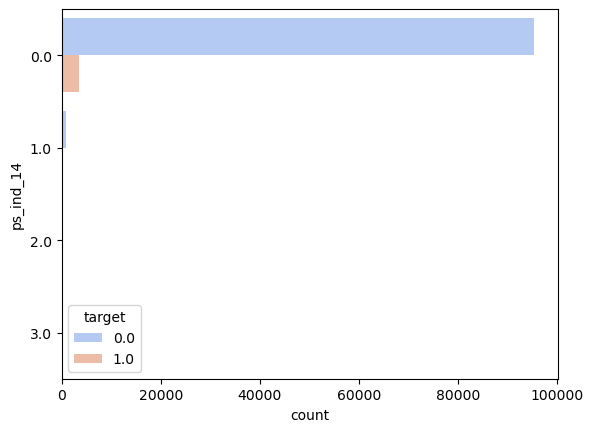

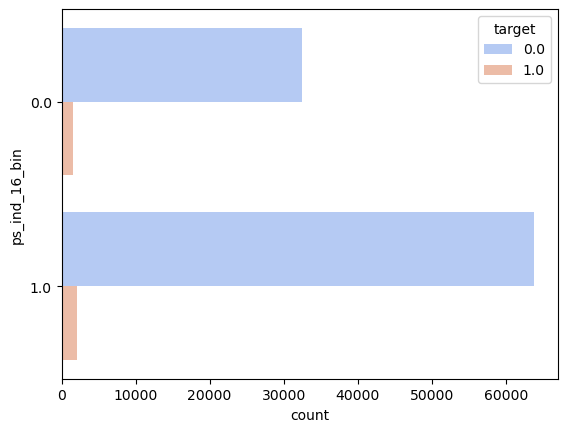

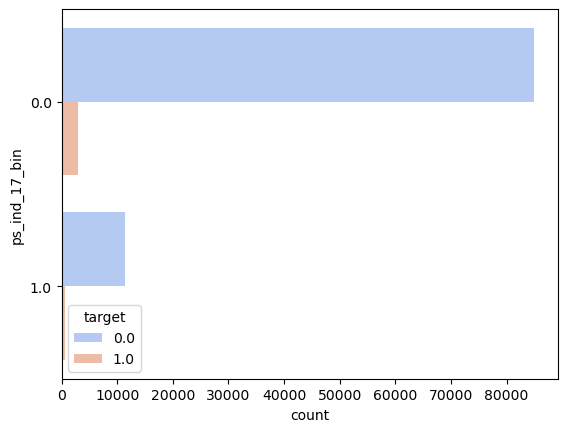

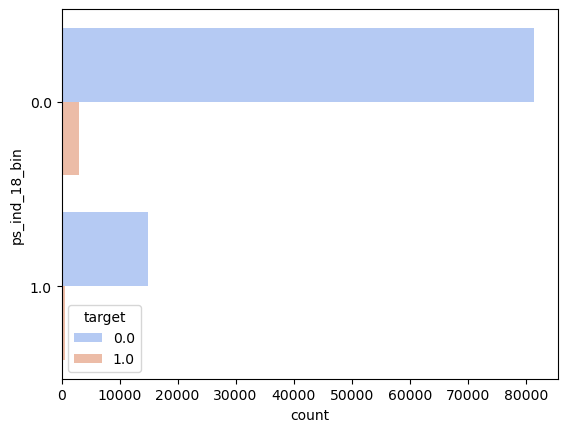

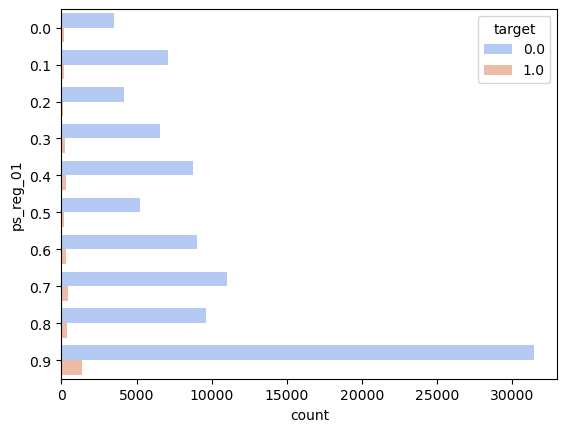

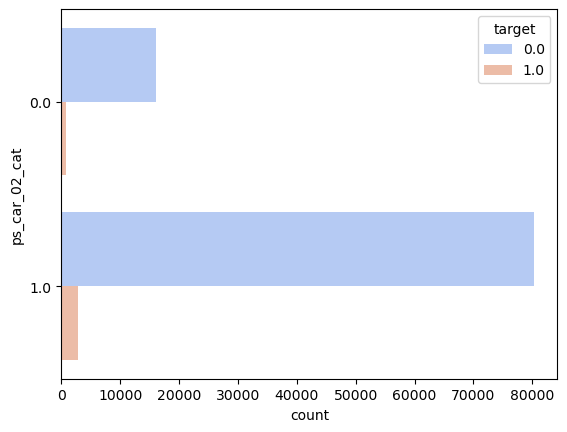

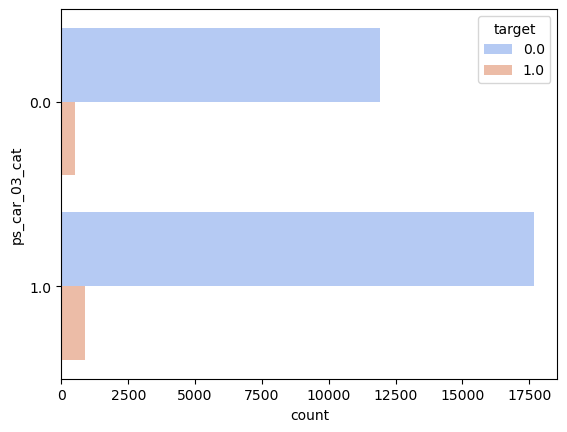

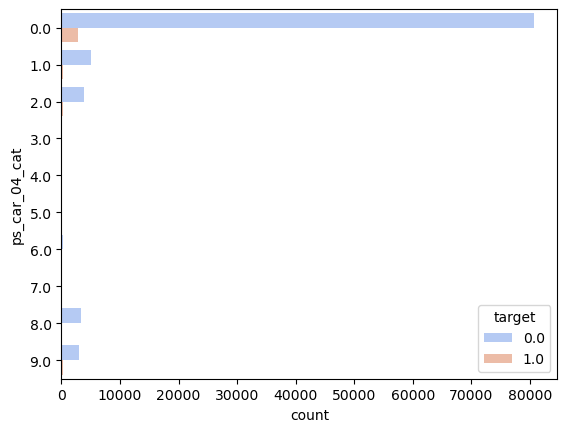

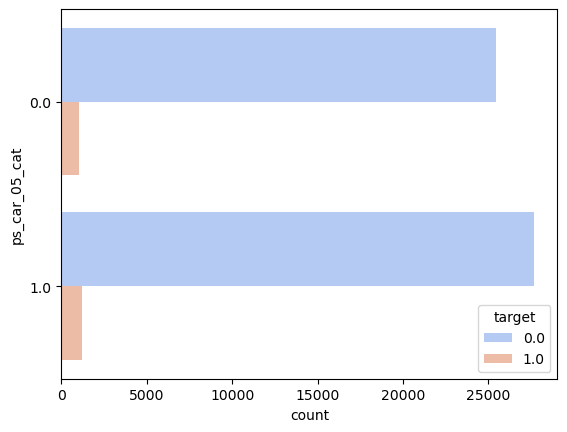

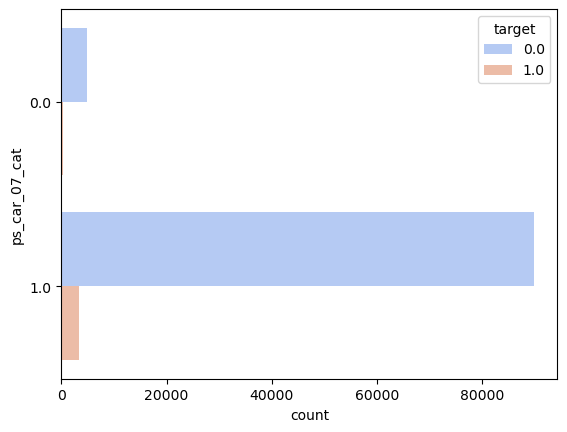

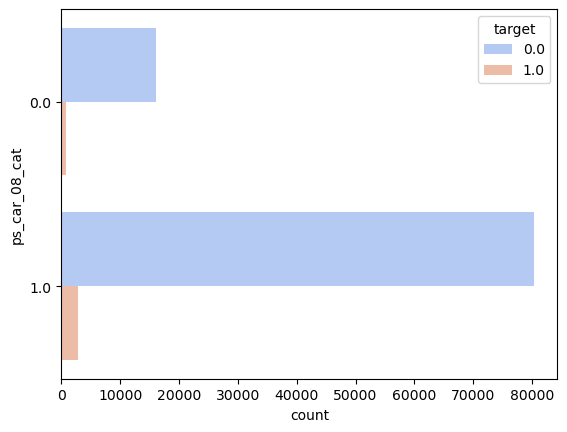

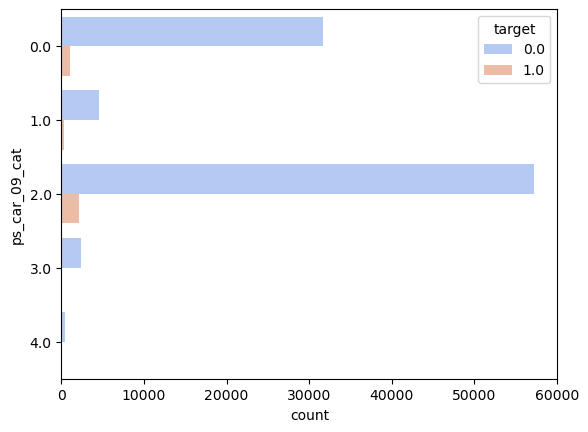

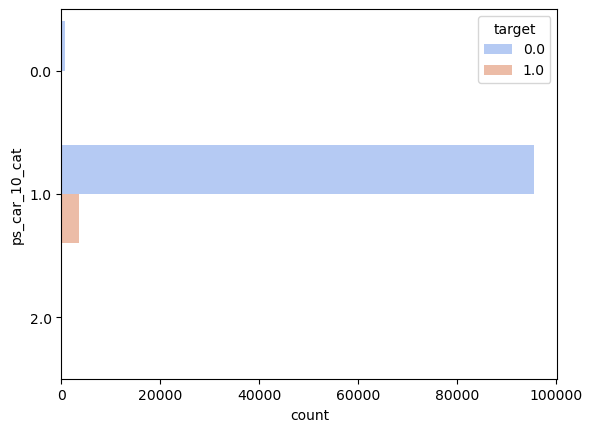

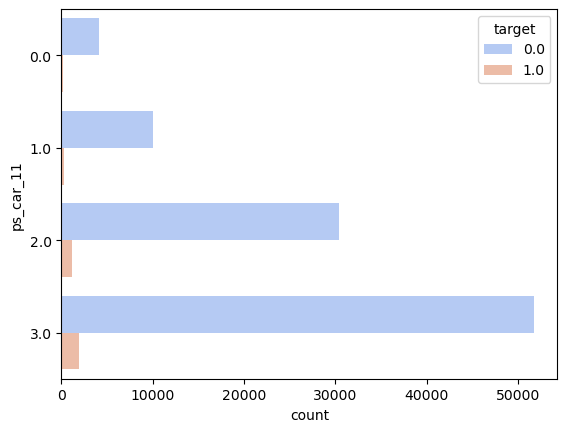

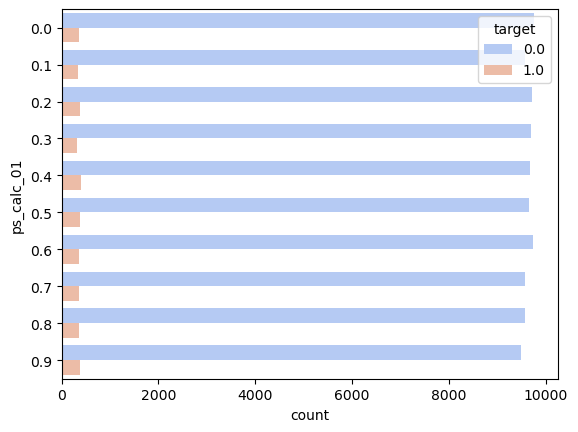

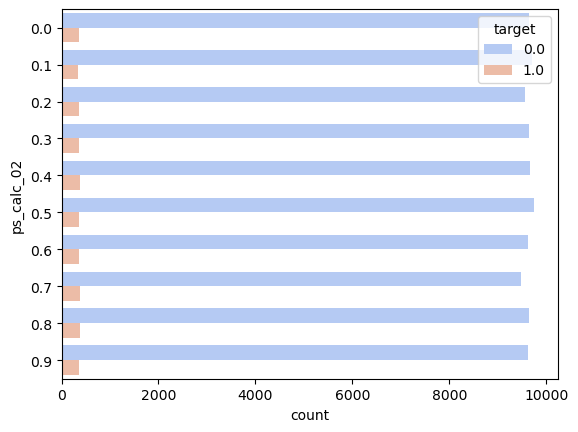

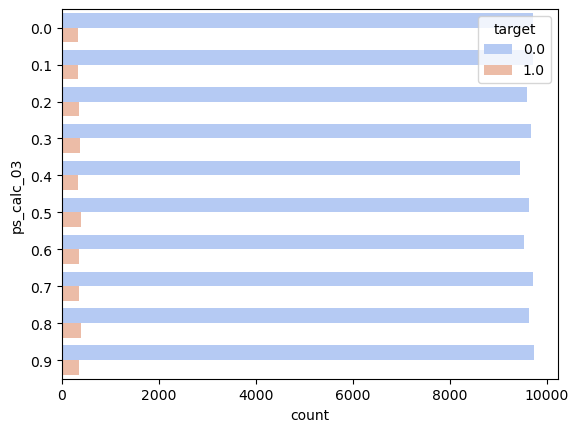

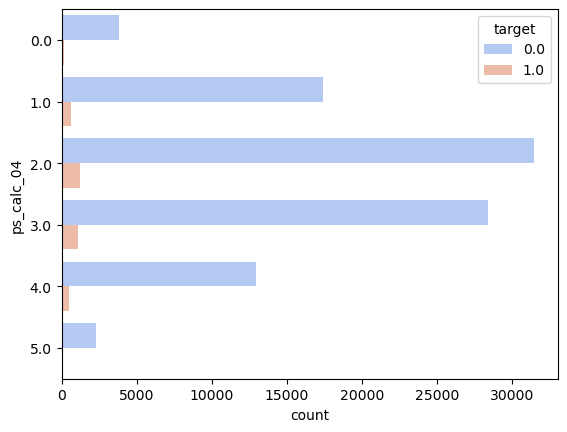

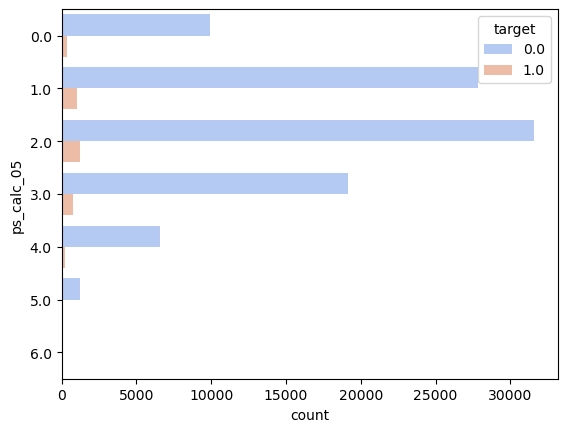

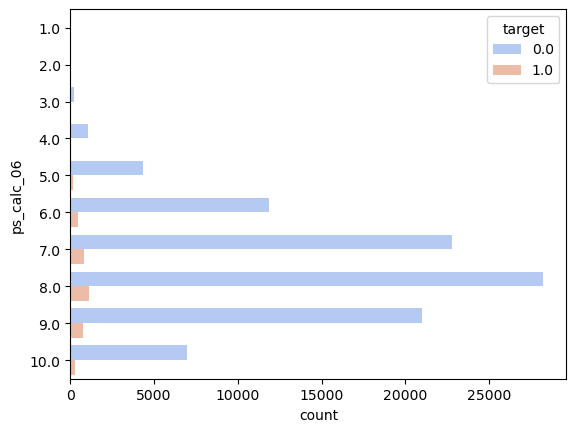

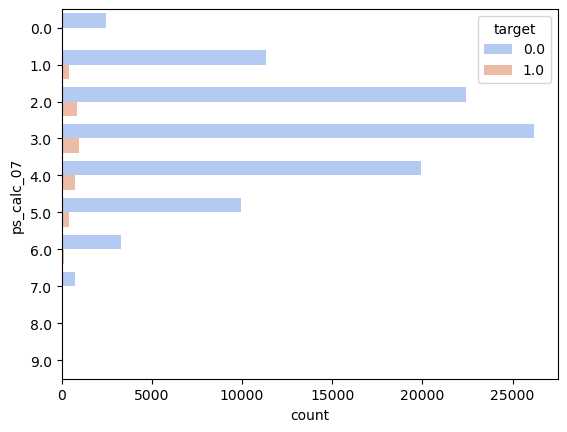

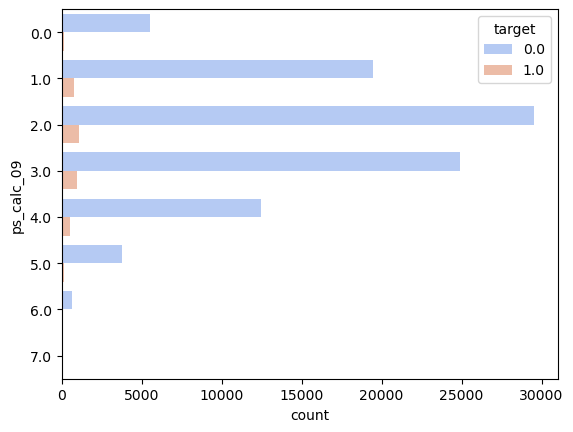

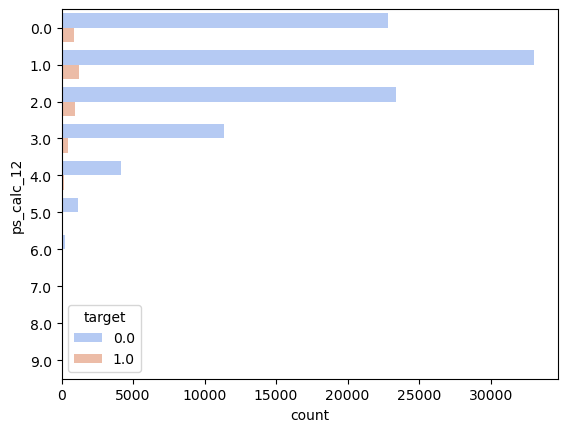

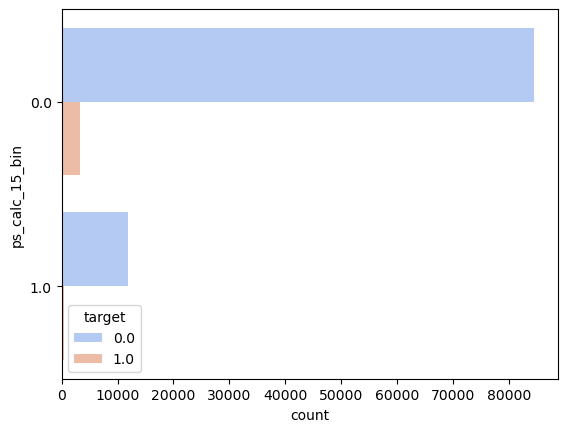

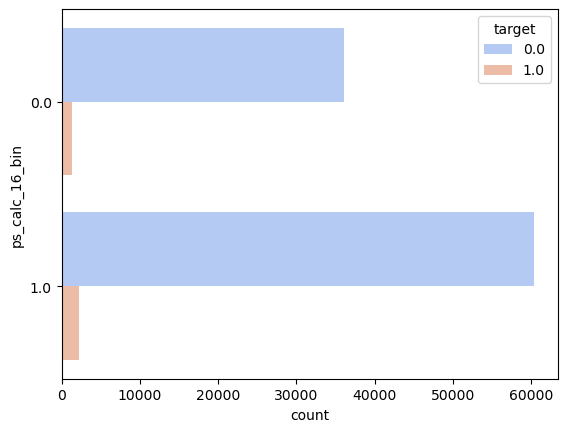

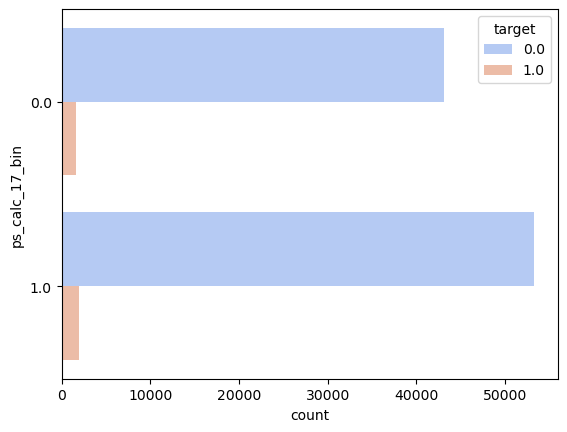

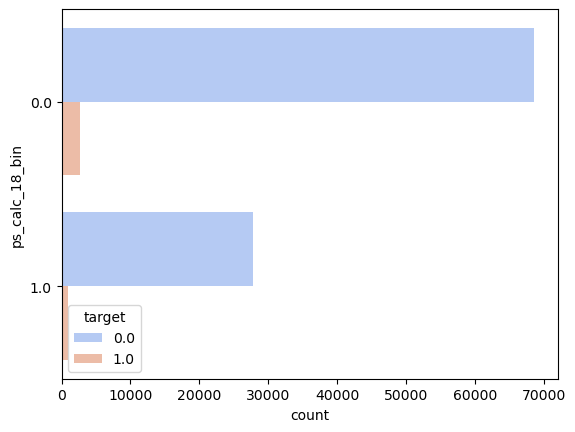

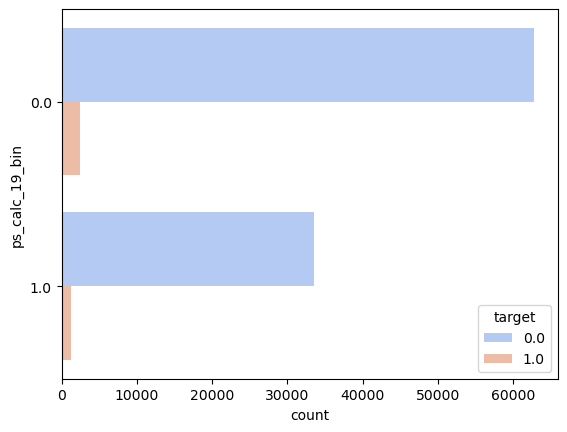

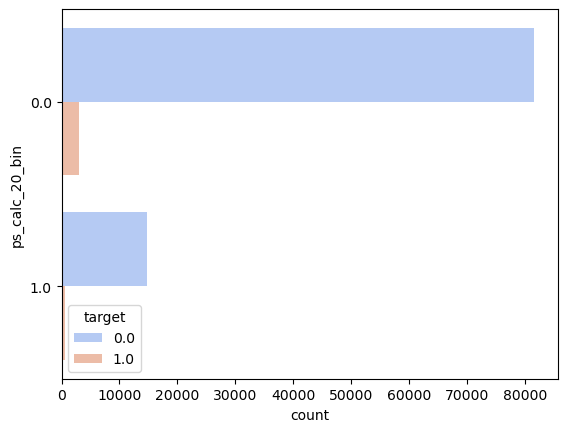

In [34]:
for column in categorical:
    
    plt.figure()
    
    sns.countplot(data = df, y = column, hue = config['EDA']['target'], palette = 'coolwarm')

### Chi-Square Test of Independence
This test is used to determine if two categorical variables are independent or if they are in fact related to one another. If two categorical variables are independent, then the value of one variable does not change the probability distribution of the other. If two categorical variables are related, then the distribution of one depends on the level the other. This test measures the differences in the observed conditional distribution of one variable across levels of the other, and compares it to the marginal (overall) distribution of that variable.



Ho: There is independence between variables

In [35]:
output = {}

for column in categorical:
    
    cross_tab = pd.crosstab(df[column], df[config['EDA']['target']])
    
    pvalue = stats.chi2_contingency(cross_tab)[1]
    
    if pvalue <= 0.05:
        
        output[column] = 'No relationship'
        
    else:
        
        output[column] = 'Relationship'
        
output

{'ps_ind_01': 'No relationship',
 'ps_ind_02_cat': 'No relationship',
 'ps_ind_04_cat': 'No relationship',
 'ps_ind_05_cat': 'No relationship',
 'ps_ind_06_bin': 'No relationship',
 'ps_ind_07_bin': 'No relationship',
 'ps_ind_08_bin': 'No relationship',
 'ps_ind_09_bin': 'No relationship',
 'ps_ind_10_bin': 'No relationship',
 'ps_ind_11_bin': 'Relationship',
 'ps_ind_12_bin': 'Relationship',
 'ps_ind_13_bin': 'Relationship',
 'ps_ind_14': 'Relationship',
 'ps_ind_16_bin': 'No relationship',
 'ps_ind_17_bin': 'No relationship',
 'ps_ind_18_bin': 'No relationship',
 'ps_reg_01': 'No relationship',
 'ps_car_02_cat': 'No relationship',
 'ps_car_03_cat': 'No relationship',
 'ps_car_04_cat': 'No relationship',
 'ps_car_05_cat': 'Relationship',
 'ps_car_07_cat': 'No relationship',
 'ps_car_08_cat': 'No relationship',
 'ps_car_09_cat': 'No relationship',
 'ps_car_10_cat': 'Relationship',
 'ps_car_11': 'No relationship',
 'ps_calc_01': 'Relationship',
 'ps_calc_02': 'Relationship',
 'ps_calc_

## Linear Separability

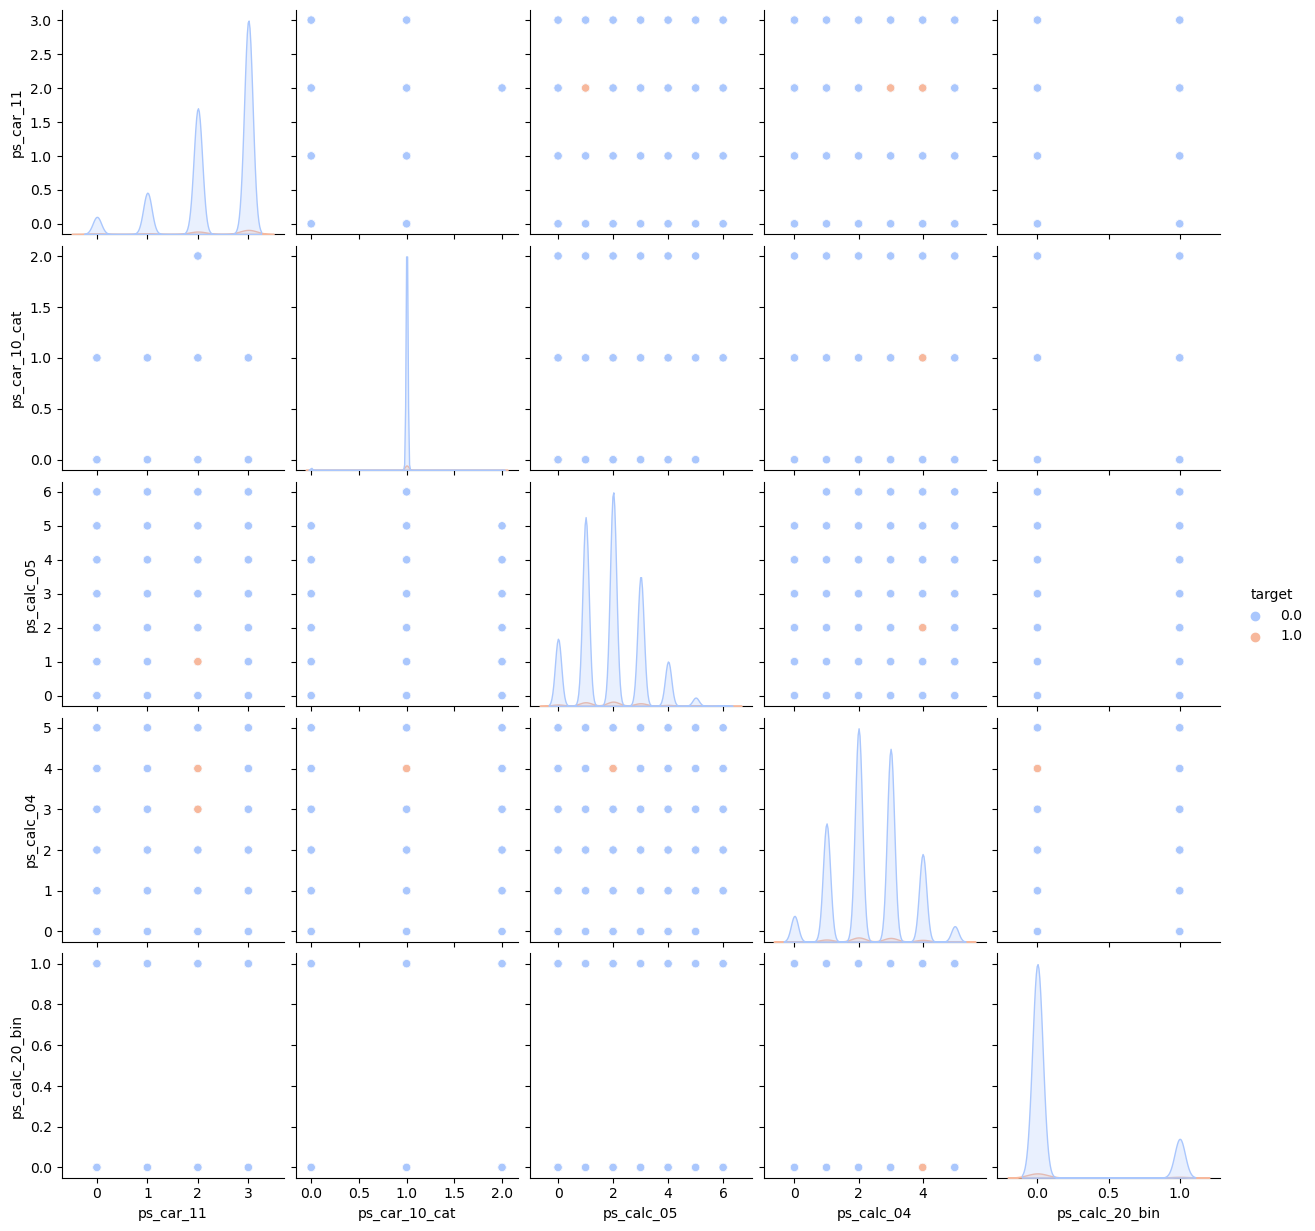

In [36]:
random_features = np.random.choice(categorical, 5).tolist()

temp = df[random_features + [config['EDA']['target']]]

sns.pairplot(data = temp, hue = config['EDA']['target'], palette = 'coolwarm', diag_kind = 'kde')

## Stats

In [37]:
features, means, medians, stds, kurts, skews, skew_type = [],[],[],[],[],[],[]

for column in numerical:
    
    features.append(column)
    
    mean_col = df[column].mean()
    means.append(mean_col)
    
    median_col = df[column].median()
    medians.append(median_col)
    
    if mean_col > median_col:
        
        skew_type.append('Right Skew')
        
    elif mean_col == median_col:
        
        skew_type.append('Normal')
        
    else:
        
        skew_type.append('Left Skew')
        
    stds.append(df[column].std())
    kurts.append(df[column].kurt())
    skews.append(df[column].skew())

stats = pd.DataFrame({'Features':features,
             'Mean':means,
             'Median':medians,
             'STD':stds,
             'Kurt':kurts,
             'Skew':skews,
             'Skew_type':skew_type,
             })


In [38]:
config['EDA']['stats_path'] = 'stats/stats.csv'

write_to_s3(stats, s3_client, config['EDA']['bucket_name'] , config['EDA']['stats_path'])

Success!


In [39]:
stats

Features       Mean     Median        STD      Kurt      Skew  \
0       ps_ind_03   4.425780   4.000000   2.704005 -0.641825  0.466087   
1       ps_ind_15   7.291770   7.000000   3.555512 -0.743823 -0.281663   
2       ps_reg_02   0.437254   0.300000   0.403417  1.163435  1.290447   
3       ps_reg_03   0.892573   0.800000   0.344801  0.940035  1.075005   
4   ps_car_01_cat   8.287903   7.000000   2.514605 -0.216373 -0.528992   
5   ps_car_06_cat   6.523500   6.000000   5.502597 -1.567803  0.110359   
6   ps_car_11_cat  62.025030  65.000000  33.013102 -1.284340 -0.226957   
7       ps_car_12   0.379914   0.374166   0.058318  5.861536  1.145471   
8       ps_car_13   0.813614   0.765568   0.223923  5.105487  1.671165   
9       ps_car_14   0.374693   0.373497   0.045848  2.051773  0.686119   
10      ps_car_15   3.069155   3.316625   0.726486  5.926753 -2.219882   
11     ps_calc_08   9.228520   9.000000   1.460075 -0.022923 -0.373764   
12     ps_calc_10   8.437990   8.000000   2.901720  0.089528  0.335282   
13     ps_calc_11   5.451250   5.000000   2.332723  0.194911  0.437721   
14     ps_calc_13   2.870140   3.000000   1.691155  0.344227  0.589124   
15     ps_calc_14   7.541140   7.000000   2.751455  0.153691  0.375798   

     Skew_type  
0   Right Skew  
1   Right Skew  
2   Right Skew  
3   Right Skew  
4   Right Skew  
5   Right Skew  
6    Left Skew  
7   Right Skew  
8   Right Skew  
9   Right Skew  
10   Left Skew  
11  Right Skew  
12  Right Skew  
13  Right Skew  
14   Left Skew  
15  Right Skew

## Correlation

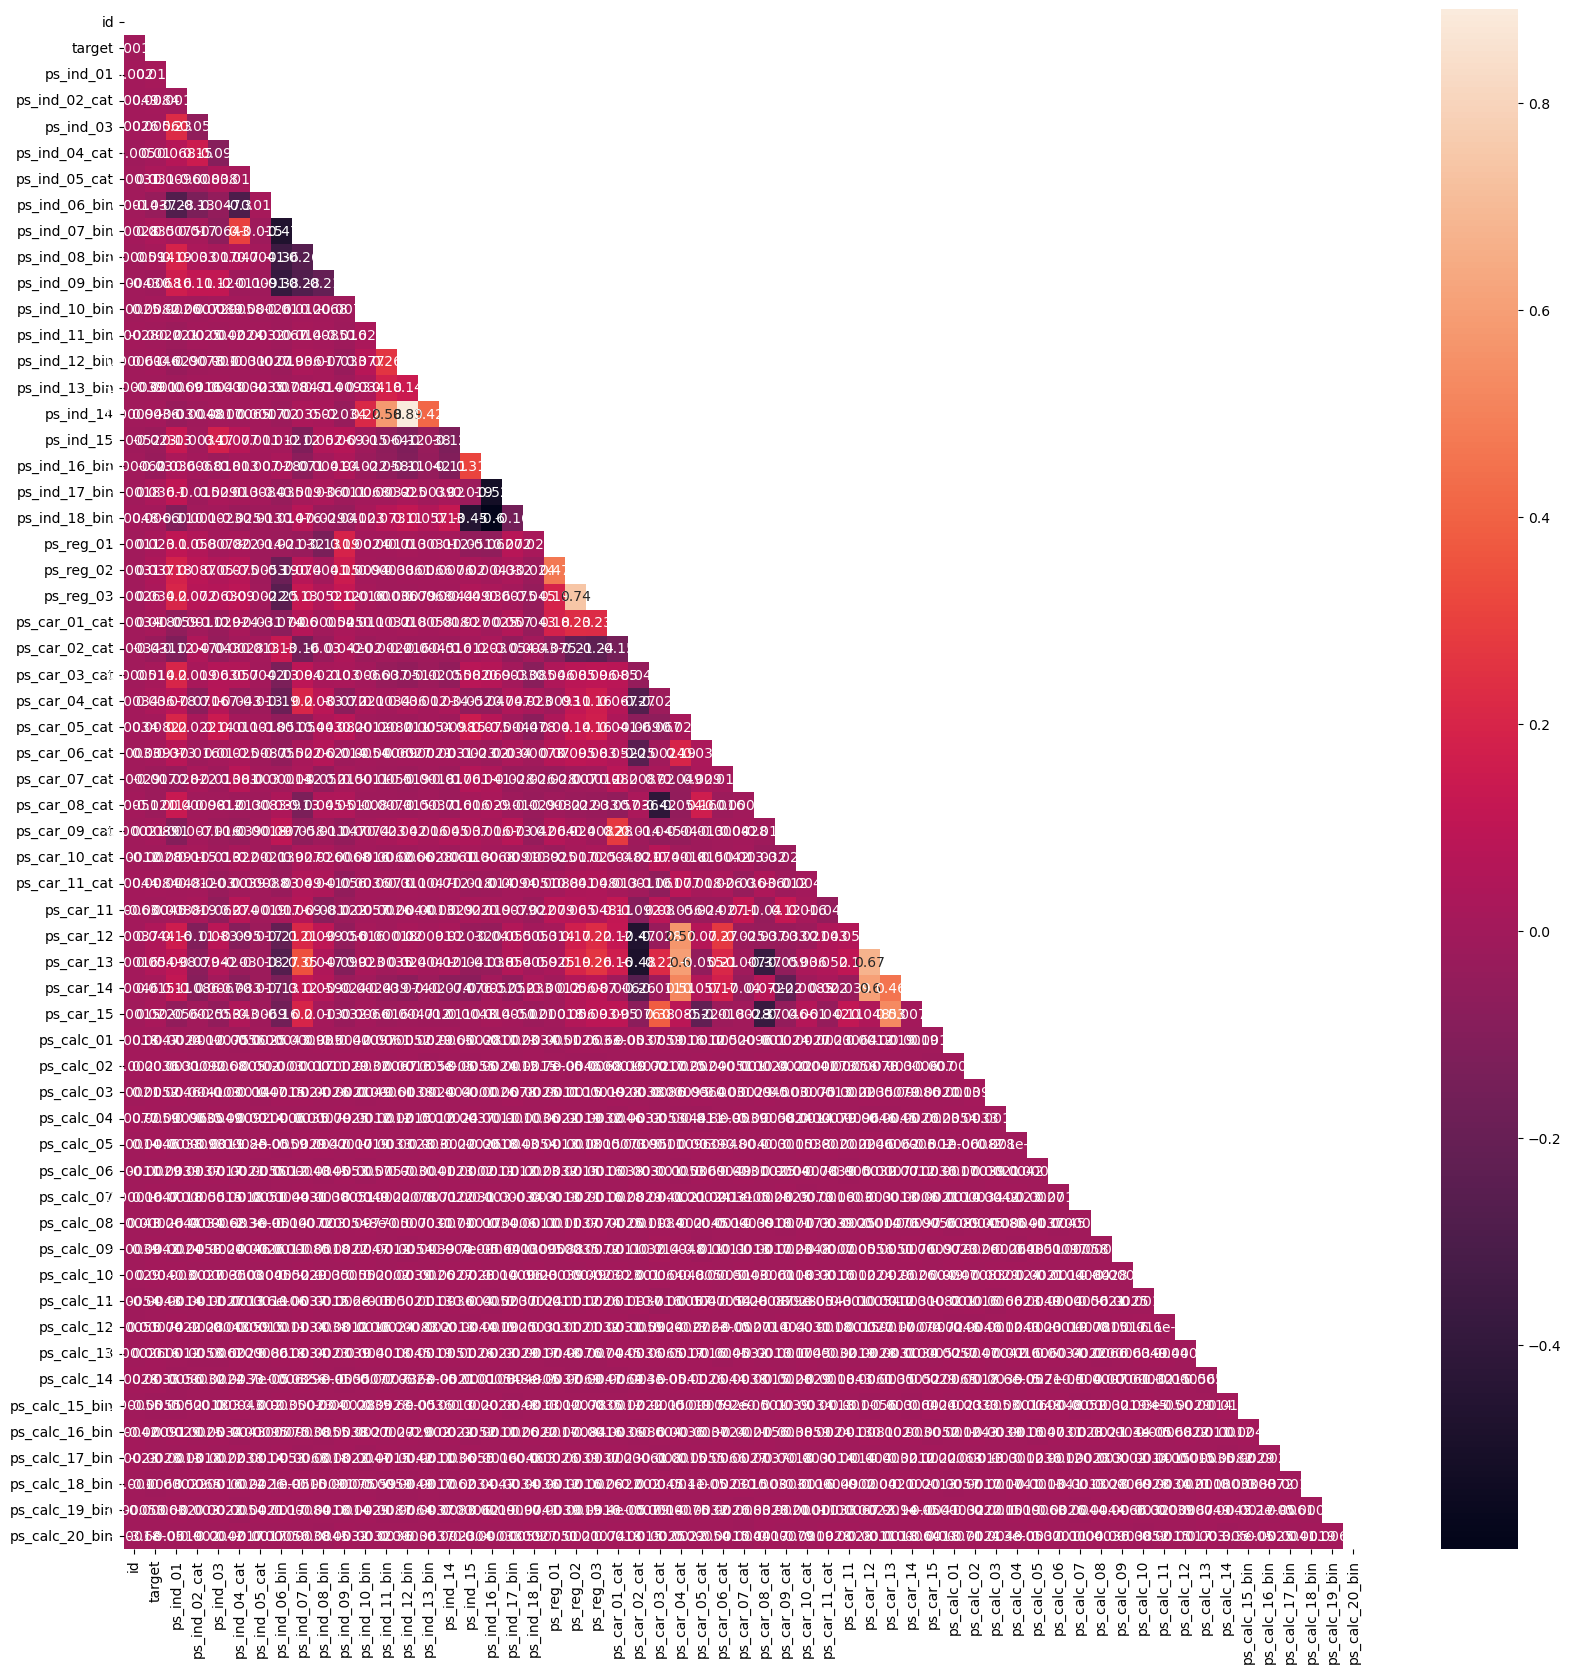

In [40]:
correlation(df, 'pearson', (20, 20), annot = True)

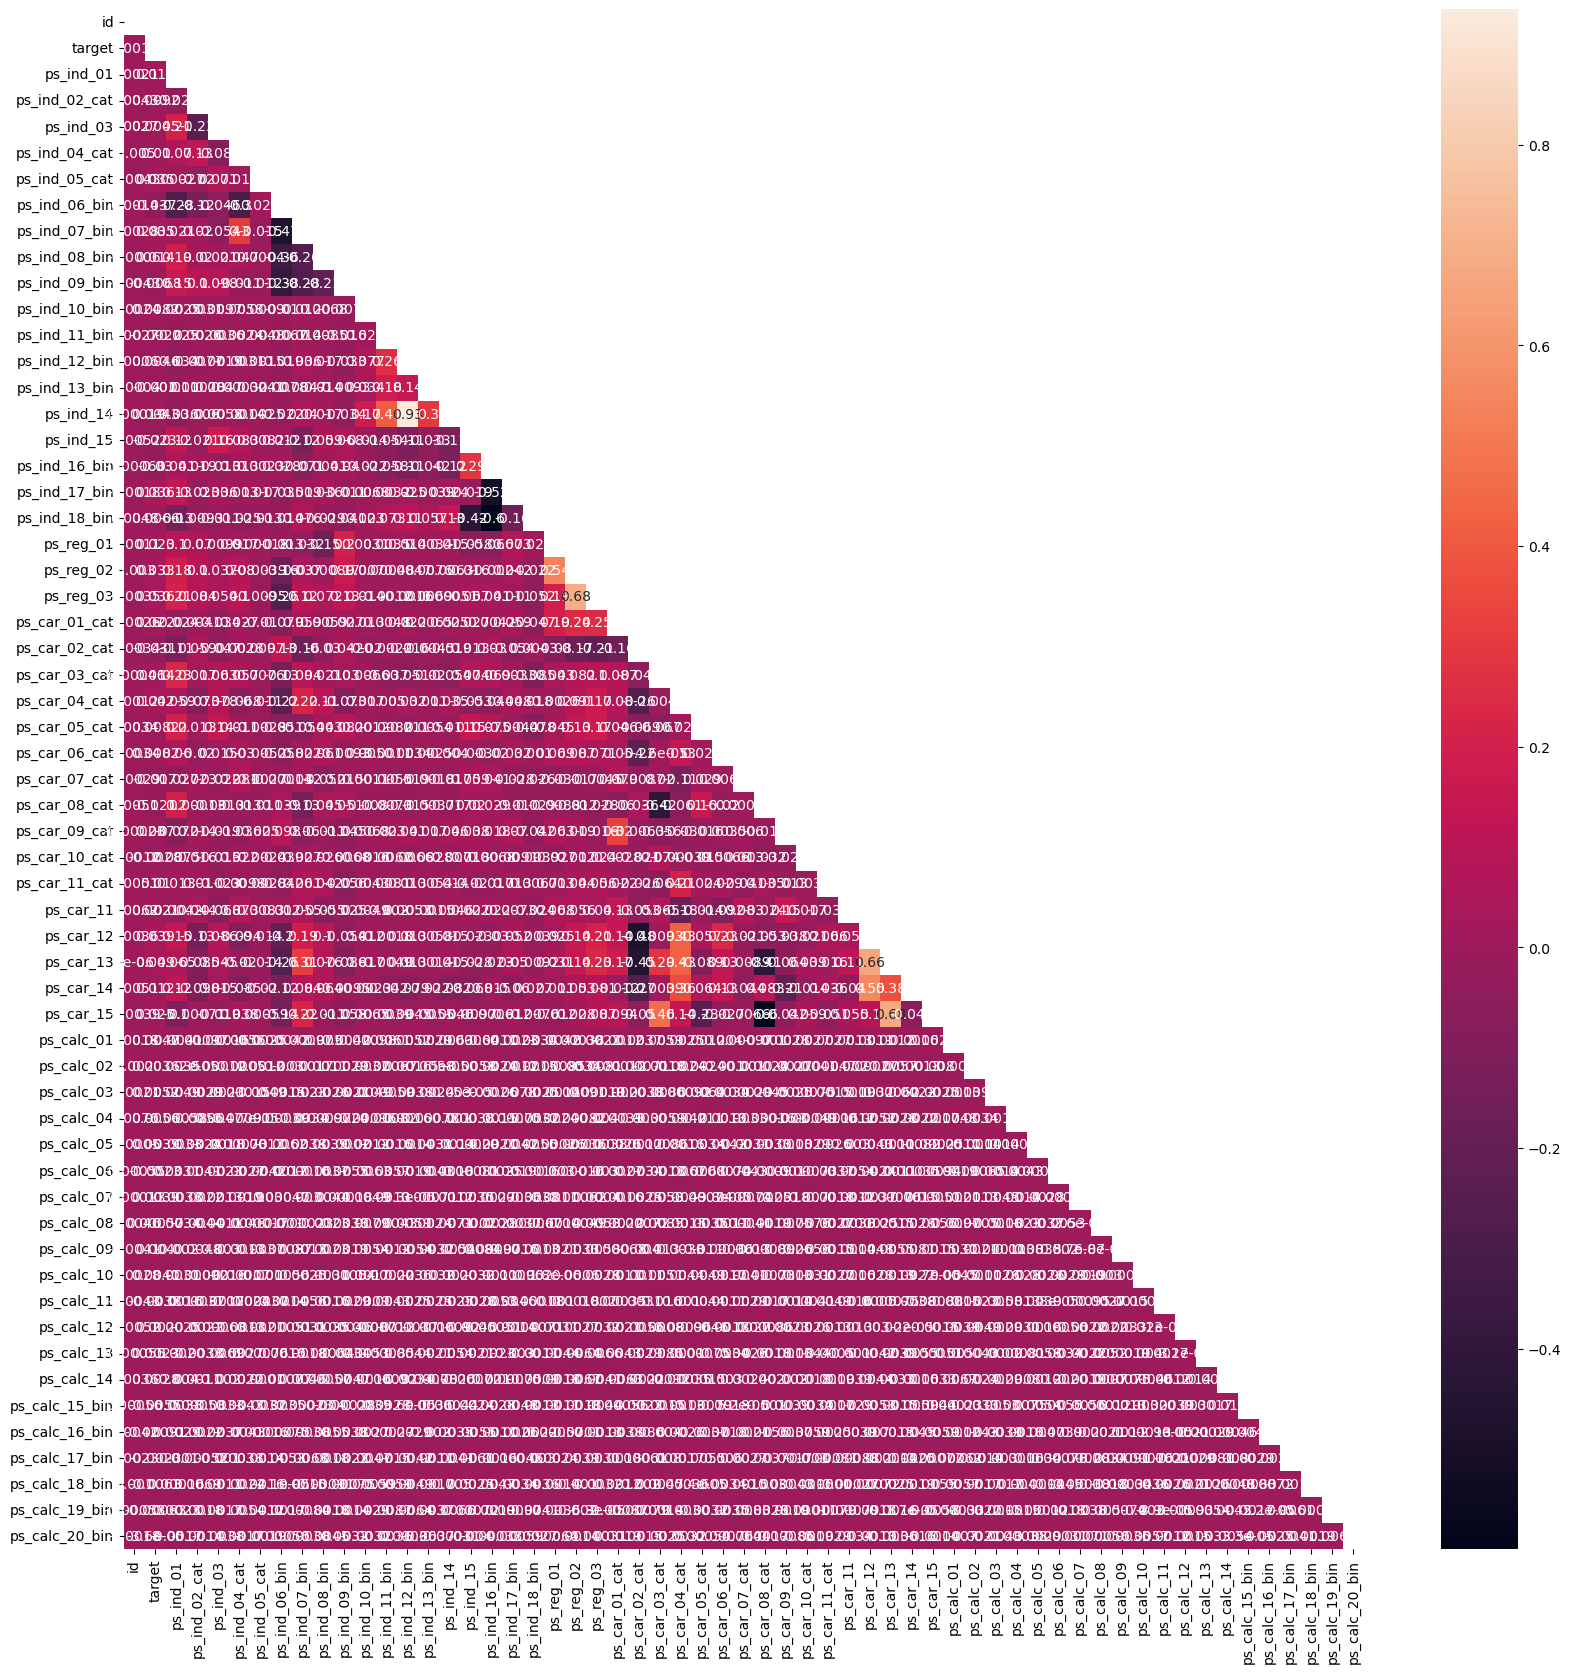

In [41]:
correlation(df, 'spearman', (20, 20), annot = True)

## Normality

### Shapiro-Wilk 

The Shapiro-Wilk test tests the null hypothesis that the
data was drawn from a normal distribution.

In [43]:
output = {}

for column in numerical:
    
    pval = scipy.stats.shapiro(df[column])[1]
    
    if pval <= 0.05:
        
        output[column] = 'The data is not normal'
        
    else:
        
        output[column] = 'The data is normal'
        
output        

{'ps_ind_03': 'The data is not normal',
 'ps_ind_15': 'The data is not normal',
 'ps_reg_02': 'The data is not normal',
 'ps_reg_03': 'The data is normal',
 'ps_car_01_cat': 'The data is normal',
 'ps_car_06_cat': 'The data is not normal',
 'ps_car_11_cat': 'The data is not normal',
 'ps_car_12': 'The data is not normal',
 'ps_car_13': 'The data is not normal',
 'ps_car_14': 'The data is normal',
 'ps_car_15': 'The data is not normal',
 'ps_calc_08': 'The data is not normal',
 'ps_calc_10': 'The data is not normal',
 'ps_calc_11': 'The data is not normal',
 'ps_calc_13': 'The data is not normal',
 'ps_calc_14': 'The data is not normal'}

### Q-Q plot

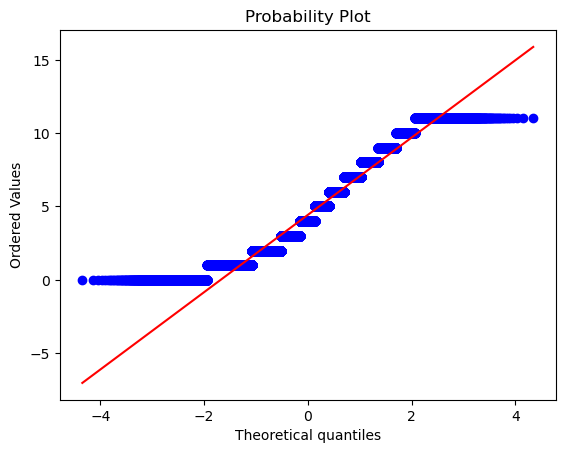

<Figure size 640x480 with 0 Axes>

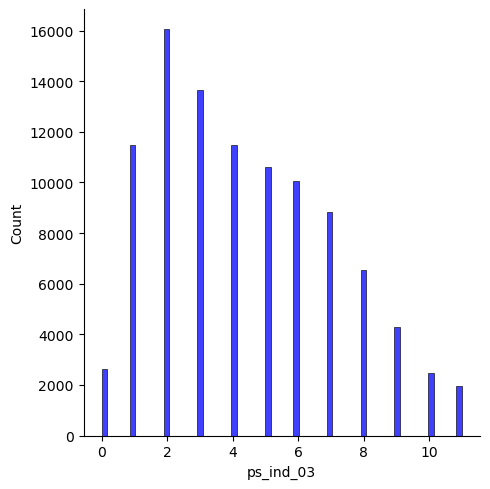

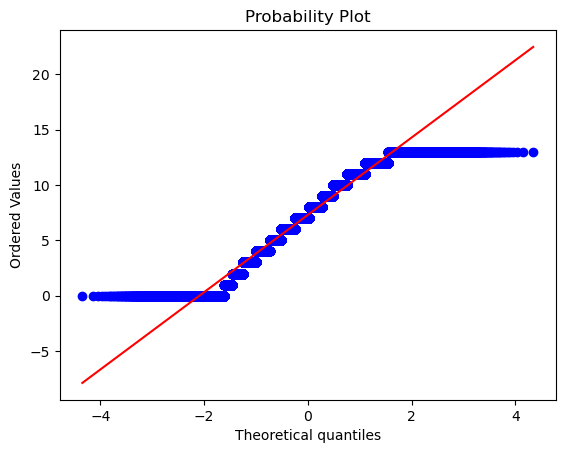

<Figure size 640x480 with 0 Axes>

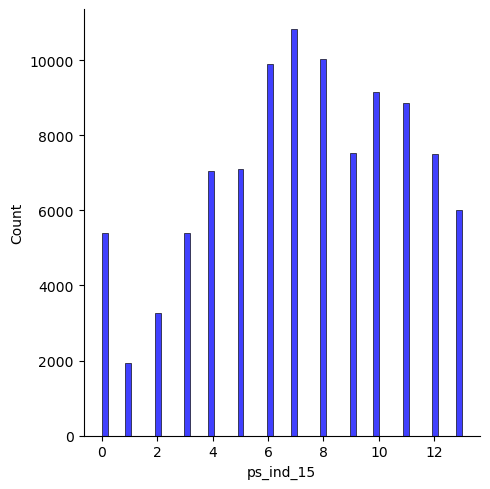

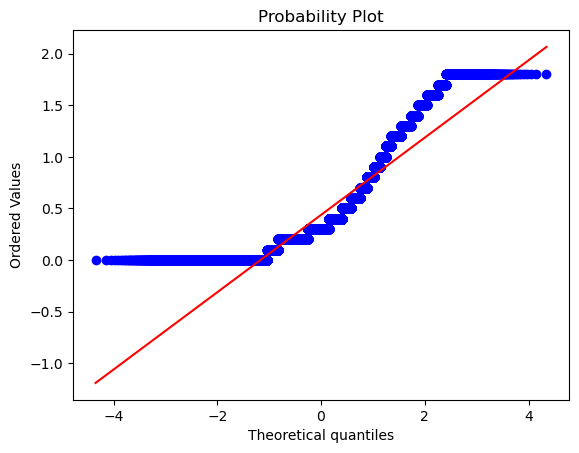

<Figure size 640x480 with 0 Axes>

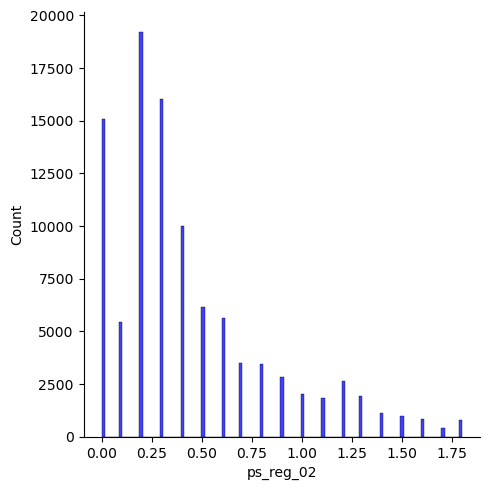

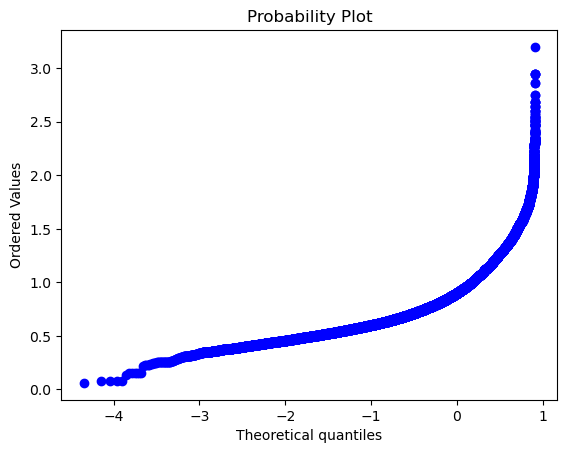

<Figure size 640x480 with 0 Axes>

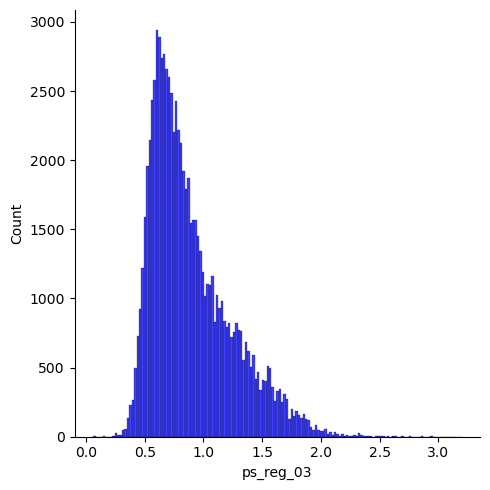

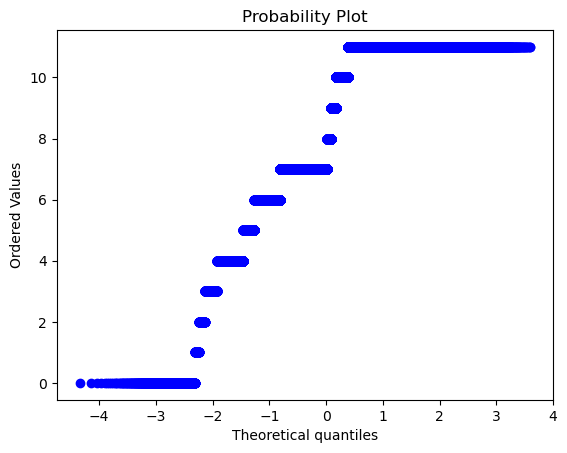

<Figure size 640x480 with 0 Axes>

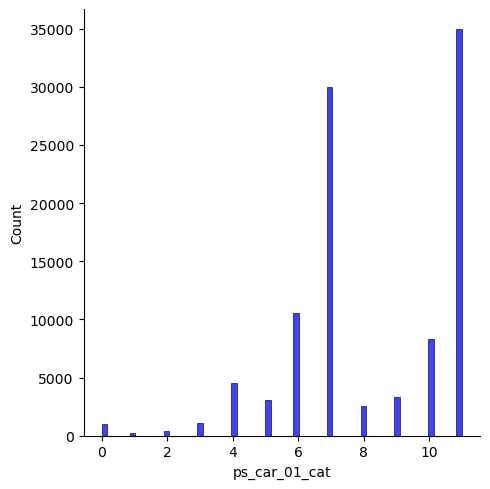

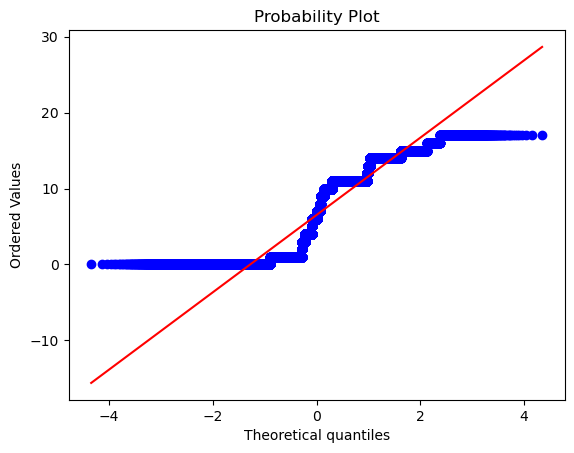

<Figure size 640x480 with 0 Axes>

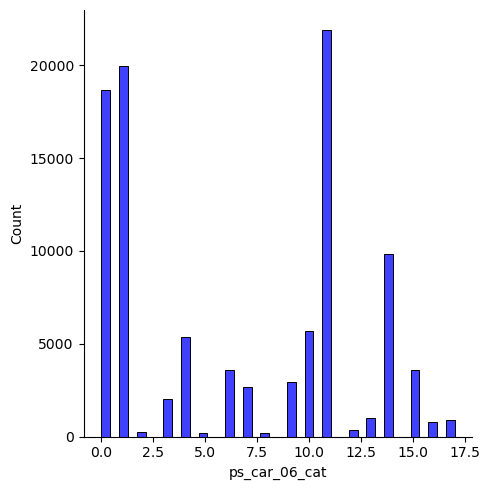

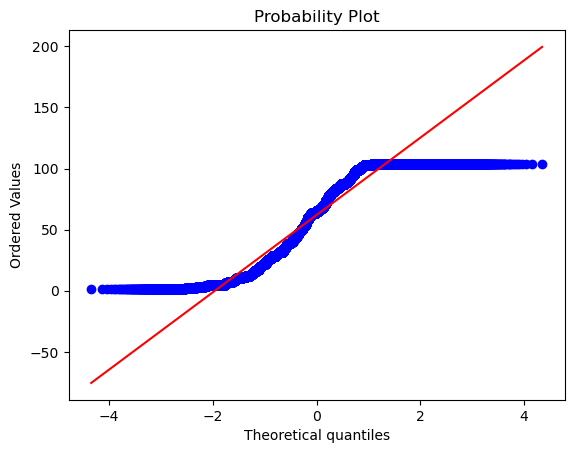

<Figure size 640x480 with 0 Axes>

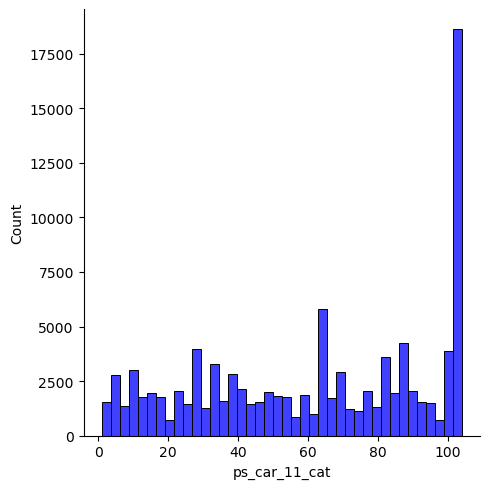

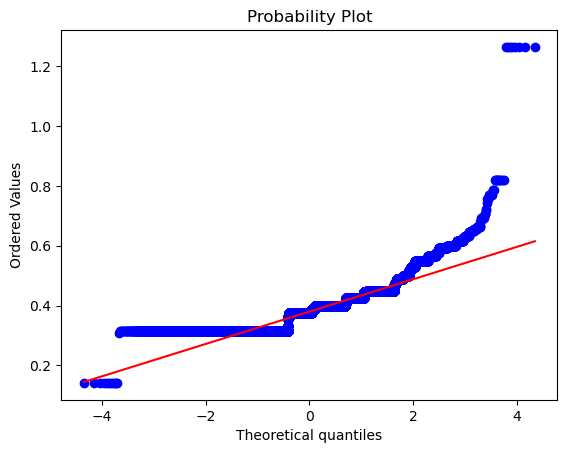

<Figure size 640x480 with 0 Axes>

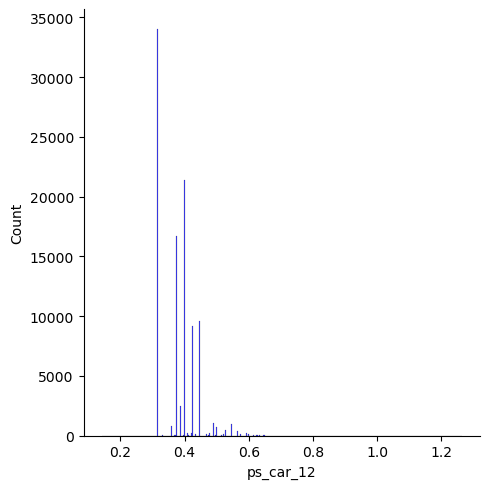

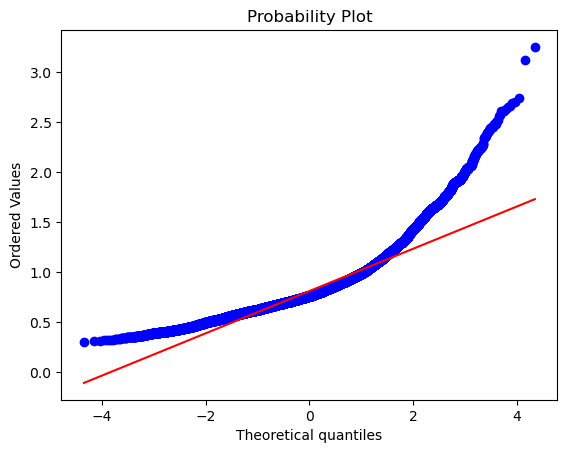

<Figure size 640x480 with 0 Axes>

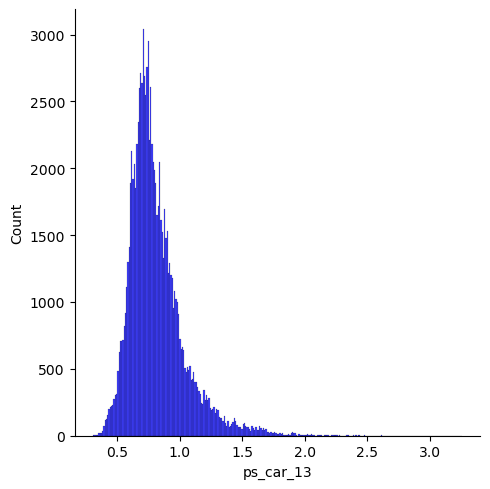

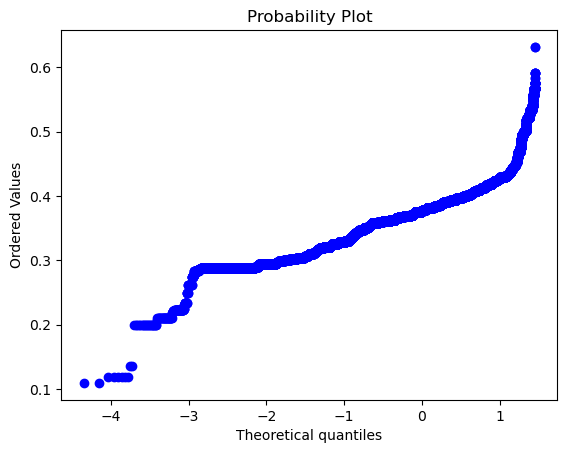

<Figure size 640x480 with 0 Axes>

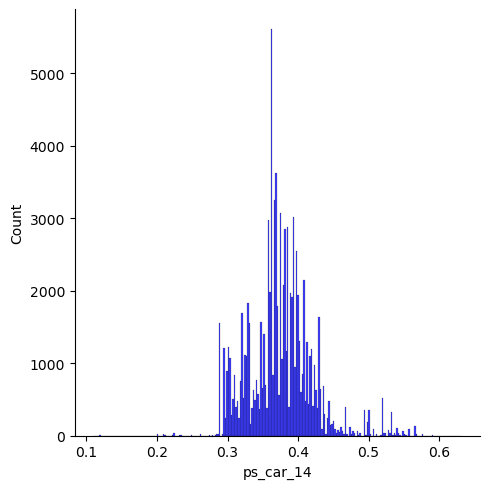

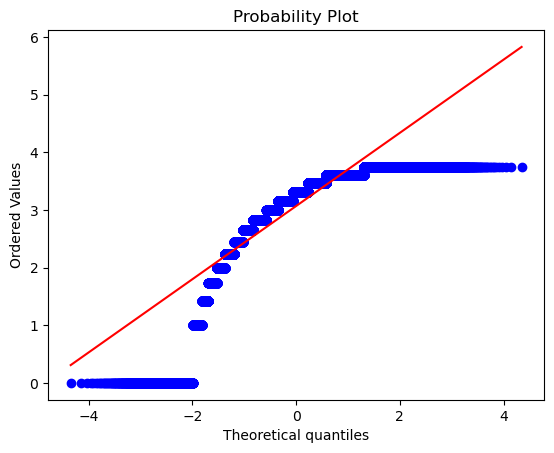

<Figure size 640x480 with 0 Axes>

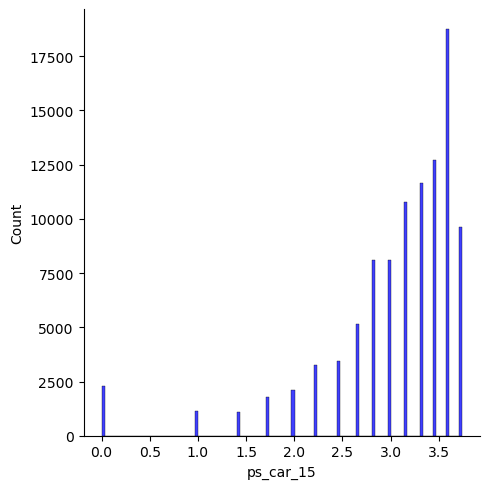

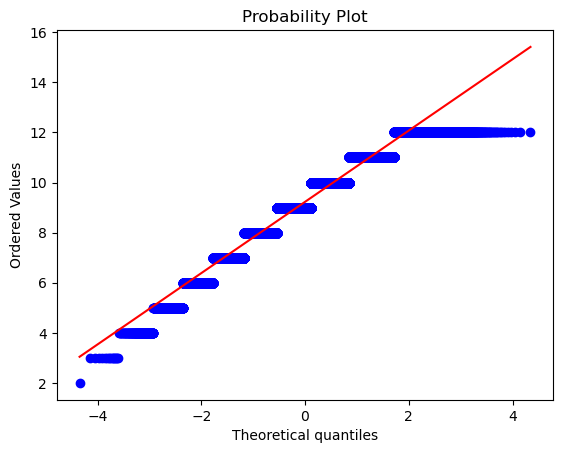

<Figure size 640x480 with 0 Axes>

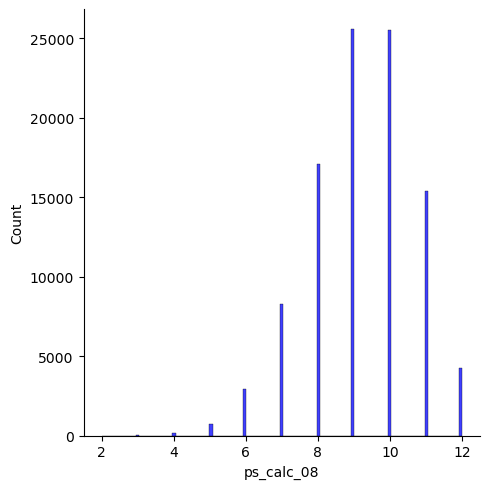

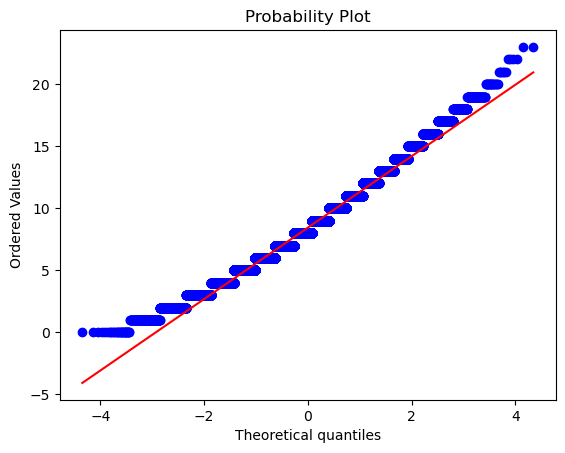

<Figure size 640x480 with 0 Axes>

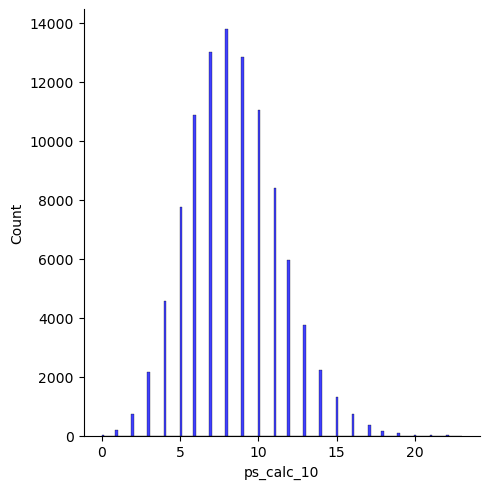

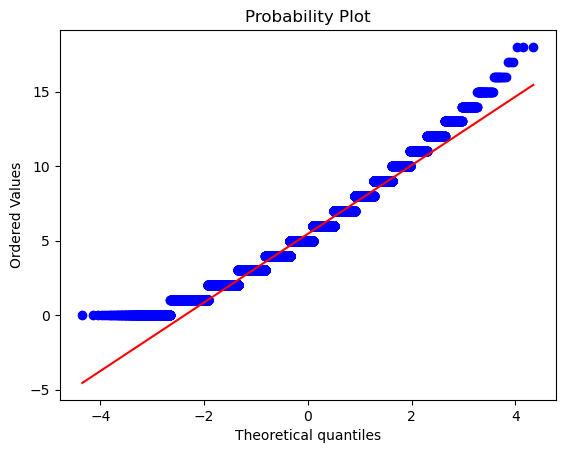

<Figure size 640x480 with 0 Axes>

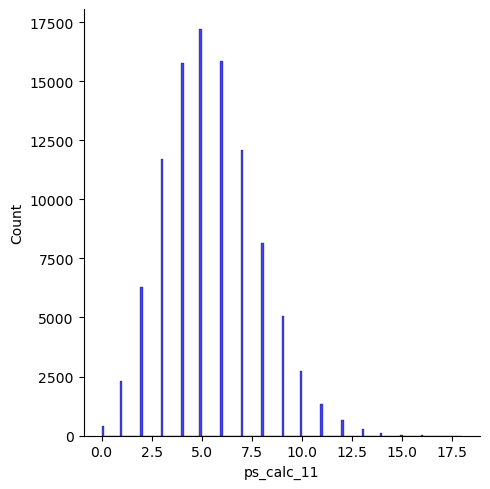

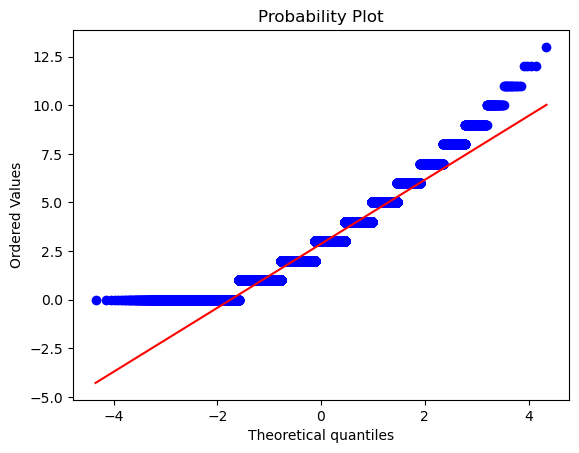

<Figure size 640x480 with 0 Axes>

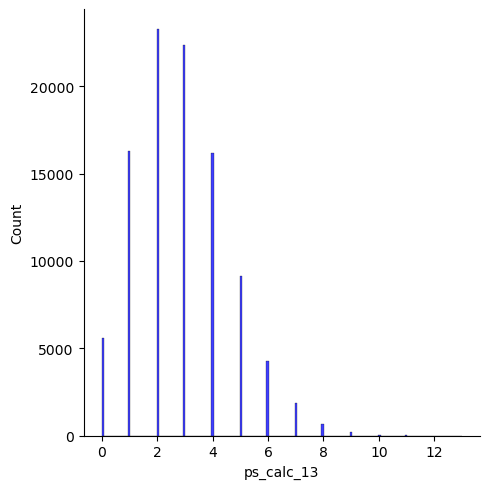

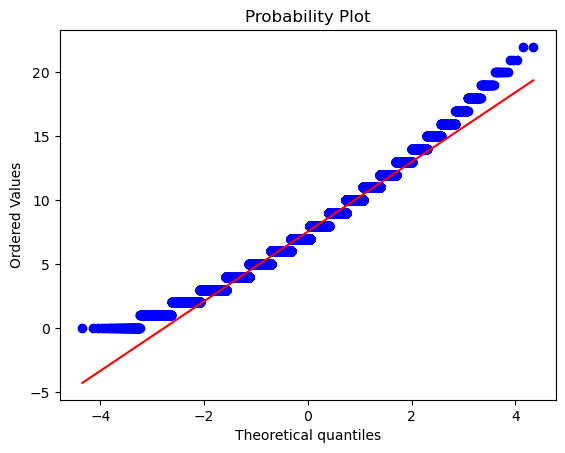

<Figure size 640x480 with 0 Axes>

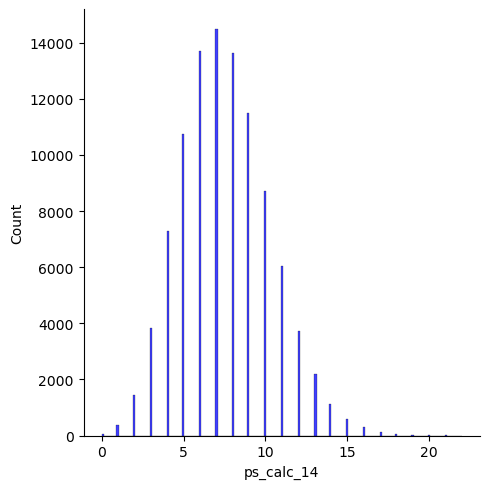

In [54]:
for column in numerical:
    
    plt.figure()
    scipy.stats.probplot(df[column], plot=plt, dist='norm')
    
    plt.figure()
    sns.displot(data = df, x = column, color = 'blue')

## Outliers

## IQR Proximity Rule

In [56]:
output = {}

for column in numerical:
    
        Q3 = df[column].quantile(0.75)
        Q1 = df[column].quantile(0.25)
        
        IQR = Q3 - Q1
        
        upper_limit = (1.5*IQR) + Q3
        lower_limit = (1.5*IQR) - Q1
        
        outliers = df.loc[np.where(df[column] > upper_limit, True, 
                 np.where(df[column] < lower_limit, True,
                          False))]
        
        output[column] = f'{round(len(outliers)/len(df),2)*100}%'
        
output

{'ps_ind_03': '44.0%',
 'ps_ind_15': '11.0%',
 'ps_reg_02': '62.0%',
 'ps_reg_03': '2.0%',
 'ps_car_01_cat': '0.0%',
 'ps_car_06_cat': '85.0%',
 'ps_car_11_cat': '43.0%',
 'ps_car_12': '3.0%',
 'ps_car_13': '5.0%',
 'ps_car_14': '3.0%',
 'ps_car_15': '0.0%',
 'ps_calc_08': '0.0%',
 'ps_calc_10': '1.0%',
 'ps_calc_11': '1.0%',
 'ps_calc_13': '7.000000000000001%',
 'ps_calc_14': '2.0%'}

## ZScore

 - How does this work?
    We need to set a threshold, for example, you can use a threshold of 3, which means that any data point with a z-score greater than 3 or less than -3 is an outlier

In [66]:
output = {}

for column in numerical:
    temp = df[[column]].copy()
    
    # Compute z-scores for the current column
    temp['zscore_col'] = np.abs(scipy.stats.zscore(temp[column]))
    
    # Identify outliers based on z-score threshold (>3 or <-3)
    outliers = temp[(temp['zscore_col'] > 3) | (temp['zscore_col'] < -3)]
    
    # Calculate percentage of outliers relative to total data points
    outlier_percentage = round(len(outliers) / len(temp) * 100, 2)
    
    # Store outlier percentage in the output dictionary
    output[column] = f'{outlier_percentage}%'

# Display the dictionary containing outlier percentages for each numerical column
output

{'ps_ind_03': '0.0%',
 'ps_ind_15': '0.0%',
 'ps_reg_02': '1.22%',
 'ps_reg_03': '0.0%',
 'ps_car_01_cat': '0.0%',
 'ps_car_06_cat': '0.0%',
 'ps_car_11_cat': '0.0%',
 'ps_car_12': '1.11%',
 'ps_car_13': '1.79%',
 'ps_car_14': '0.0%',
 'ps_car_15': '2.31%',
 'ps_calc_08': '0.17%',
 'ps_calc_10': '0.25%',
 'ps_calc_11': '0.42%',
 'ps_calc_13': '0.93%',
 'ps_calc_14': '0.51%'}

# Write to json

In [75]:
# Serializing json
json_object = json.dumps(config, indent=4)
 
# Writing to sample.json
with open("C:/Users/Oamen/OneDrive/Documents/DATA PROJECTS/Insurance_claim_prediction_porto/config.json", "w") as outfile:
    outfile.write(json_object)